0. **[Stuff](#0.-Stuff)**<br>
    0.1 [Imports](#0.1-Imports)<br>
    0.2 [Definitions](#0.2-Definitions)<br>
    0.3 [Functions](#0.3-Functions)<br>
1. **[Compute electron lifetime](#1.-Compute-electron-lifetime)**<br>
2. **[Compute corrected s2](#2.-Compute-corrected-s2)**<br>
3. **[Plots](#3.-Plots)**<br>
    3.1 [Drift time histogram](#3.1-Drift-time-histogram)<br>
    3.2 [Fit each slice of the histogram](#3.2-Fit-each-slice-of-the-histogram)<br>
    3.3 [Extract the electron lifetime](#3.3-Extract-the-electron-lifetime)<br>
    3.4 [Average s2 size (uncorrected)](#3.4-Average-s2-size-(uncorrected))<br>
    3.5 [Average s2 size (corrected)](#3.5-Average-s2-size-(corrected))<br>
    3.6 [Correction along the TPC (before)](#3.6-Correction-along-the-TPC-(before))<br>
    3.7 [Correction along the TPC (after)](#3.7-Correction-along-the-TPC-(after))<br>

# 0. Stuff

## 0.1 Imports

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colors
from matplotlib.colors import LogNorm

%matplotlib inline
from scipy.optimize import curve_fit, minimize,fmin
#import strax
import straxbra
from matplotlib.ticker import AutoMinorLocator
from matplotlib.image import NonUniformImage
import pandas as pd
import patrick_stylez as ps
from scipy.stats import chi2 
import math
from scipy import stats

Using TensorFlow backend.


## 0.2 Definitions

In [64]:
ctx = straxbra.XebraContext()
run = '00197'
peaks_data = ctx.get_array(run, 'peaks')
position_data = ctx.get_array(run, 'peak_positions')
waveform = peaks_data['data']
integral = peaks_data['area']
width = peaks_data['width'][:,5]
timestamp = peaks_data['time']
risetime = -peaks_data['area_decile_from_midpoint'][:,1]
area_per_channel = peaks_data['area_per_channel']
x_position = position_data['x']
y_position = position_data['y']

In [65]:
left_edge  = [0, 0]
right_edge = [40500.0, -71.5]
a = ((right_edge[1])-(left_edge[1])) / ((right_edge[0])-(left_edge[0]))
b = (right_edge[1]) - a * (right_edge[0])
fiducial_r = 21
num = len(waveform)

## 0.3 Functions

In [66]:
def single_gaus(x, h, mu, sigma):

    gaus = h * np.exp(-(np.log(x)-mu)**2         /(2*sigma**2))
    return gaus

def log_gaus(x, h, mu, sigma):

    log_gaus = h * np.exp(-(np.log(x)-mu)**2         /(2*sigma**2))
    return log_gaus

def log_fit( x, a, mu, sigma ):
    return a / x * 1. / (sigma * np.sqrt( 2. * np.pi ) ) * np.exp( -( np.log( x ) - mu )**2 / ( 2. * sigma**2 ) )




def poisson_interval(k, alpha=0.318):
    a = alpha
    low, high = (chi2.ppf(a/2, 2*k) / 2, chi2.ppf(1-a/2, 2*k + 2) / 2)
    if k == 0:
        low = 0.0
    low_interval = k - low
    high_interval = high - k
    return low_interval, high_interval

def expo(x, a, b):
    return a*np.exp(-b*x)

def compute_lifetime(s2,drifttime):

    
    bins_x = np.linspace(0,50,50)
    bins_y = np.logspace(3,4.5,50) 
    drifttime = np.array(drifttime)
    counts, xedges, yedges = np.histogram2d(drifttime/1e3, s2, bins=(bins_x, bins_y))
    ycenter = ((yedges[:-1]+yedges[1:])/2)
    poisson_list = []
    for i in counts:
        error_per_slice = []
        for j in i:
            a =poisson_interval(j)[1]
            error_per_slice.append(a)
        poisson_list.append(error_per_slice)
        
    fit_range= np.linspace(10,30000,1000)

    

    p0 = [50,8,2]

    expectation_list = []
    error_list = []
    for i in range(5,35):   
        popt, pcov = curve_fit(log_gaus, ycenter, counts[i], p0= p0, sigma = poisson_list[i], absolute_sigma = True, maxfev = 10000)
        perr = np.sqrt(np.diag(pcov))

        expectation = np.exp(popt[1]+((popt[2]**2)/2))
        expectation_list.append(expectation)

    
        diff_mu = expectation
        diff_sigma = expectation*popt[2]
        error_mu = perr[1]
        error_sigma = perr[2]
    
        error = np.sqrt(diff_mu**2 * error_mu**2 + diff_sigma**2 * error_sigma**2)
        error_list.append(error)
    
 
    p1=  [10000,0.1]
    x = np.linspace(5,35,30)
    popt, pcov = curve_fit(expo, x, expectation_list, sigma=error_list, p0=p1, absolute_sigma=True, maxfev= 10000)
    lifetime =(1/popt[1])
    lifetime_error =(1/(popt[1]**2))*perr[1]
#    print('electron lifetime: ', lifetime, '+/-', lifetime_error)
    
    return (lifetime, lifetime_error)




def CutCondition(waveform):  
    FirstPeak_area = sum(waveform[:15])
    SecondPeak_area = sum(waveform[15:])    
    if  FirstPeak_area > 100 and FirstPeak_area < 500 and SecondPeak_area > 40 and SecondPeak_area  < 200: 
        return(True)
    else:
        return(False)

    
    
# def CutCondition(waveform):  
#     FirstPeak_area = sum(waveform[:15])
#     SecondPeak_area = sum(waveform[15:])
#     FirstPeak_maximum = max(waveform[:15])
#     SecondPeak_maximum = max(waveform[15:])
#     SecondPeak_index = np.where(waveform == SecondPeak_maximum)
#     SecondPeak_index_left = SecondPeak_index[0][0] -1
#     SecondPeak_index_right = SecondPeak_index[0][0] +1
#     SecondPeak_maximum_left = waveform[SecondPeak_index_left]
#     SecondPeak_maximum_right = waveform[SecondPeak_index_right]

    
    
    
#     if  FirstPeak_area > 100 and FirstPeak_area < 500 and SecondPeak_area > 40 and SecondPeak_area  < 200 \
#     and SecondPeak_maximum < 0.5 * FirstPeak_maximum \
#     and SecondPeak_maximum > 0.25 * FirstPeak_maximum \
#     and SecondPeak_maximum > waveform[SecondPeak_index_left] \
#     and SecondPeak_maximum > waveform[SecondPeak_index_right] \
#     : 
#         return(True)
#     else:
#         return(False)
    
    

def drifttime_to_z(t):
    return a * t + b


def poisson_interval(k, alpha=0.318):
    a = alpha
    low, high = (chi2.ppf(a/2, 2*k) / 2, chi2.ppf(1-a/2, 2*k + 2) / 2)
    if k == 0:
        low = 0.0
    low_interval = k - low
    high_interval = high - k
    return low_interval, high_interval

def S2_found(integral, width):
    if integral > 500 and width >200 and width < 2000:
        return True
    else:
        return False

    
def Process(waveform, i): 
    SelectionCutFlag = CutCondition(waveform[i])
    if SelectionCutFlag == True:
        j = 1
        counter_timestamp = timestamp[i+j]
        threshold_timestamp = timestamp[i] + 45000
        while threshold_timestamp >= counter_timestamp and  S2_found(integral = integral[i+j], width = width[i+j]) == False:  
            j += 1
            counter_timestamp = timestamp[i+j]
        else:
            if S2_found(integral = integral[i+j], width = width[i+j]):

                k=1 
                s2_counter_timestamp = timestamp[i+j+k]
                z_position = drifttime_to_z(timestamp[i+j] - timestamp[i])
                while threshold_timestamp >= s2_counter_timestamp and S2_found(integral = integral[i+j+k], width = width[i+j+k]) == False:
                    k += 1
                    s2_counter_timestamp = timestamp[i+j+k]
                else:

                    if threshold_timestamp <= s2_counter_timestamp and z_position >= -70 and z_position <= -5:
#                         r_position = np.sqrt(x_position[i+j]**2 + y_position[i+j]**2)
#                         z_position = drifttime_to_z(timestamp[i+j] - timestamp[i])
                        #r_position = np.sqrt(x_position[i+j]**2 + y_position[i+j]**2)
                        time       = timestamp[i+j] - timestamp[i]
                        drifttime.append(time)
                        s2.append(integral[i+j])
                        
                        
                        
#                         if area_per_channel[i+j][1] > 0 and area_per_channel[i+j][2] > 0 \
#                             and area_per_channel[i+j][3] > 0 and area_per_channel[i+j][4] > 0 \
#                             and area_per_channel[i+j][5] > 0 and area_per_channel[i+j][6] > 0 \
#                             and area_per_channel[i+j][7] > 0 \
#                             :
#                             r_position = np.sqrt(x_position[i+j]**2 + y_position[i+j]**2)
#                             z_position = drifttime_to_z(timestamp[i+j] - timestamp[i])
#                             #r_position = np.sqrt(x_position[i+j]**2 + y_position[i+j]**2)
#                             if r_position <= fiducial_r and z_position >= -70 and z_position <= -5:
#                                 time       = timestamp[i+j] - timestamp[i]
#                                 drifttime.append(time)
#                                 s2.append(integral[i+j])

                return
            else:
                return
            

def Process_corrected(waveform, i,electron_lifetime): 
    SelectionCutFlag = CutCondition(waveform[i])
    if SelectionCutFlag == True:

        j = 1
        counter_timestamp = timestamp[i+j]
        threshold_timestamp = timestamp[i] + 45000
        while threshold_timestamp >= counter_timestamp and  S2_found(integral = integral[i+j], width = width[i+j]) == False:  
            j += 1
            counter_timestamp = timestamp[i+j]
        else:
            if S2_found(integral = integral[i+j], width = width[i+j]):

                k=1 
                s2_counter_timestamp = timestamp[i+j+k]
                z_position = drifttime_to_z(timestamp[i+j] - timestamp[i])
                while threshold_timestamp >= s2_counter_timestamp and S2_found(integral = integral[i+j+k], width = width[i+j+k]) == False:
                    k += 1
                    s2_counter_timestamp = timestamp[i+j+k]
                else:


                    if threshold_timestamp <= s2_counter_timestamp and z_position >= -70 and z_position <= -5:

                        ctime       = timestamp[i+j] - timestamp[i]
                        S2 = integral[i+j]
                        s2_corrected = S2/(np.exp(-ctime/(electron_lifetime*1e3)))
                        cs2.append(s2_corrected)
                        z.append(z_position)
#                         if area_per_channel[i+j][1] > 0 and area_per_channel[i+j][2] > 0 \
#                             and area_per_channel[i+j][3] > 0 and area_per_channel[i+j][4] > 0 \
#                             and area_per_channel[i+j][5] > 0 and area_per_channel[i+j][6] > 0 \
#                             and area_per_channel[i+j][7] > 0 \
#                             :

#                             r_position = np.sqrt(x_position[i+j]**2 + y_position[i+j]**2)
#                             z_position = drifttime_to_z(timestamp[i+j] - timestamp[i])
#                             if r_position <= fiducial_r and z_position >= -70 and z_position <= -5:
#                                 time       = timestamp[i+j] - timestamp[i]
#                                 drifttime.append(time)
#                                 S2 = integral[i+j]
#                                 s2_corrected = S2/(np.exp(-time/(electron_lifetime*10e3)))
#                                 cs2.append(s2_corrected)
#                                 z.append(z_position)
                return
            else:
                return

In [73]:
def compute_lifetime(s2,drifttime):
    
    bins_x = np.linspace(0,50,45)
    bins_y = np.logspace(2,4.5,45) 
    drifttime = np.array(drifttime)
    counts, xedges, yedges = np.histogram2d(drifttime/1e3, s2, bins=(bins_x, bins_y))
    ycenter = ((yedges[:-1]+yedges[1:])/2)
    poisson_list = []
    for i in counts:
        error_per_slice = []
        for j in i:
            a =poisson_interval(j)[1]
            error_per_slice.append(a)
        poisson_list.append(error_per_slice)
        
    fit_range= np.linspace(1000,30000,1000)

    

    p0 = [50,8,2]

    expectation_list = []
    error_list = []
    for i in range(5,25):   
        popt, pcov = curve_fit(log_fit, ycenter, counts[i], p0= p0, sigma = poisson_list[i], absolute_sigma = True)
        perr = np.sqrt(np.diag(pcov))

        
        
        expectation = np.exp(popt[1]-popt[2]**2)
        expectation_list.append(expectation)
        diff_mu = expectation
        diff_sigma = expectation * 2 * popt[2]
        error_mu = perr[1]
        error_sigma = perr[2] 
        error = np.sqrt(diff_mu**2 * error_mu**2 + diff_sigma**2 * error_sigma**2)
        error_list.append(error)
        
        
        
#         expectation = np.exp(popt[1]+((popt[2]**2)/2))
#         expectation_list.append(expectation)

    
#         diff_mu = expectation
#         diff_sigma = expectation*popt[2]
#         error_mu = perr[1]
#         error_sigma = perr[2]
    
#         error = np.sqrt(diff_mu**2 * error_mu**2 + diff_sigma**2 * error_sigma**2)
#         error_list.append(error)
    
 
    p1=  [10000,0.1]
    x = np.linspace(5,25,20)
    popt, pcov = curve_fit(expo, x, expectation_list, sigma=error_list, p0=p1, absolute_sigma=True, maxfev= 10000)
    perr = np.sqrt(np.diag(pcov))
    lifetime =(1/popt[1])
    lifetime_error =(1/(popt[1]**2))*perr[1]
    print('electron lifetime: ', lifetime, '+/-', lifetime_error)
    
    return (lifetime, lifetime_error)






# 1. Compute electron lifetime

In [74]:
s2 = []
drifttime = []
                                                      

print_counter = 0.0
for i in range(0,num-10):    
    Process(waveform,i)
    if i/num >= print_counter:
        print(round(print_counter,2), end = ' ')
        print_counter += 0.1
print(1.0, '        Run ',run, 'done!')
    


0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00197 done!


In [75]:
electron_lifetime, lifetime_error = compute_lifetime(s2,drifttime)    


electron lifetime:  10.0 +/- inf


/software/anaconda3/envs/strax/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


In [8]:
# fig, axes = ps.styles()





# drifttime = np.array(drifttime)


# bins_x = np.linspace(0,50,50)
# bins_y = np.logspace(2,5,50)
# counts, xedges, yedges = np.histogram2d(drifttime/1e3, s2, bins=(bins_x, bins_y))
# xcenter = ((xedges[:-1]+xedges[1:])/2)
# ycenter = ((yedges[:-1]+yedges[1:])/2)

# poisson_list = []

# for i in counts:
#     error_per_slice = []
#     for j in i:
#         a =poisson_interval(j)[1]
#         error_per_slice.append(a)
#     poisson_list.append(error_per_slice)
    

    
# im = axes.pcolormesh(bins_x, bins_y, counts.T, cmap='viridis', norm=mcolors.LogNorm())
# axes.set_yscale('log')
# axes.set_xlabel('Drift time [us]')
# axes.set_ylabel('S2')
# cbar = plt.colorbar(im, ax=axes)
# cbar.set_label('Counts',size=20)
# cbar.ax.tick_params(labelsize=20) 
# plt.show()


# 2. Compute corrected s2

In [9]:

cs2 = []
z = []

print_counter = 0.0
for i in range(0,num-10):    
    Process_corrected(waveform,i,electron_lifetime)
    if i/num >= print_counter:
        print(round(print_counter,2), end = ' ')
        print_counter += 0.1
print(1.0, '        Run ',run, 'done!')


0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00199 done!


In [10]:
print(len(cs2))
print(len(z))
print(len(s2))
print(len(drifttime))

10166
10166
10166
10166


# 3. Plots

## 3.1 Drift time histogram

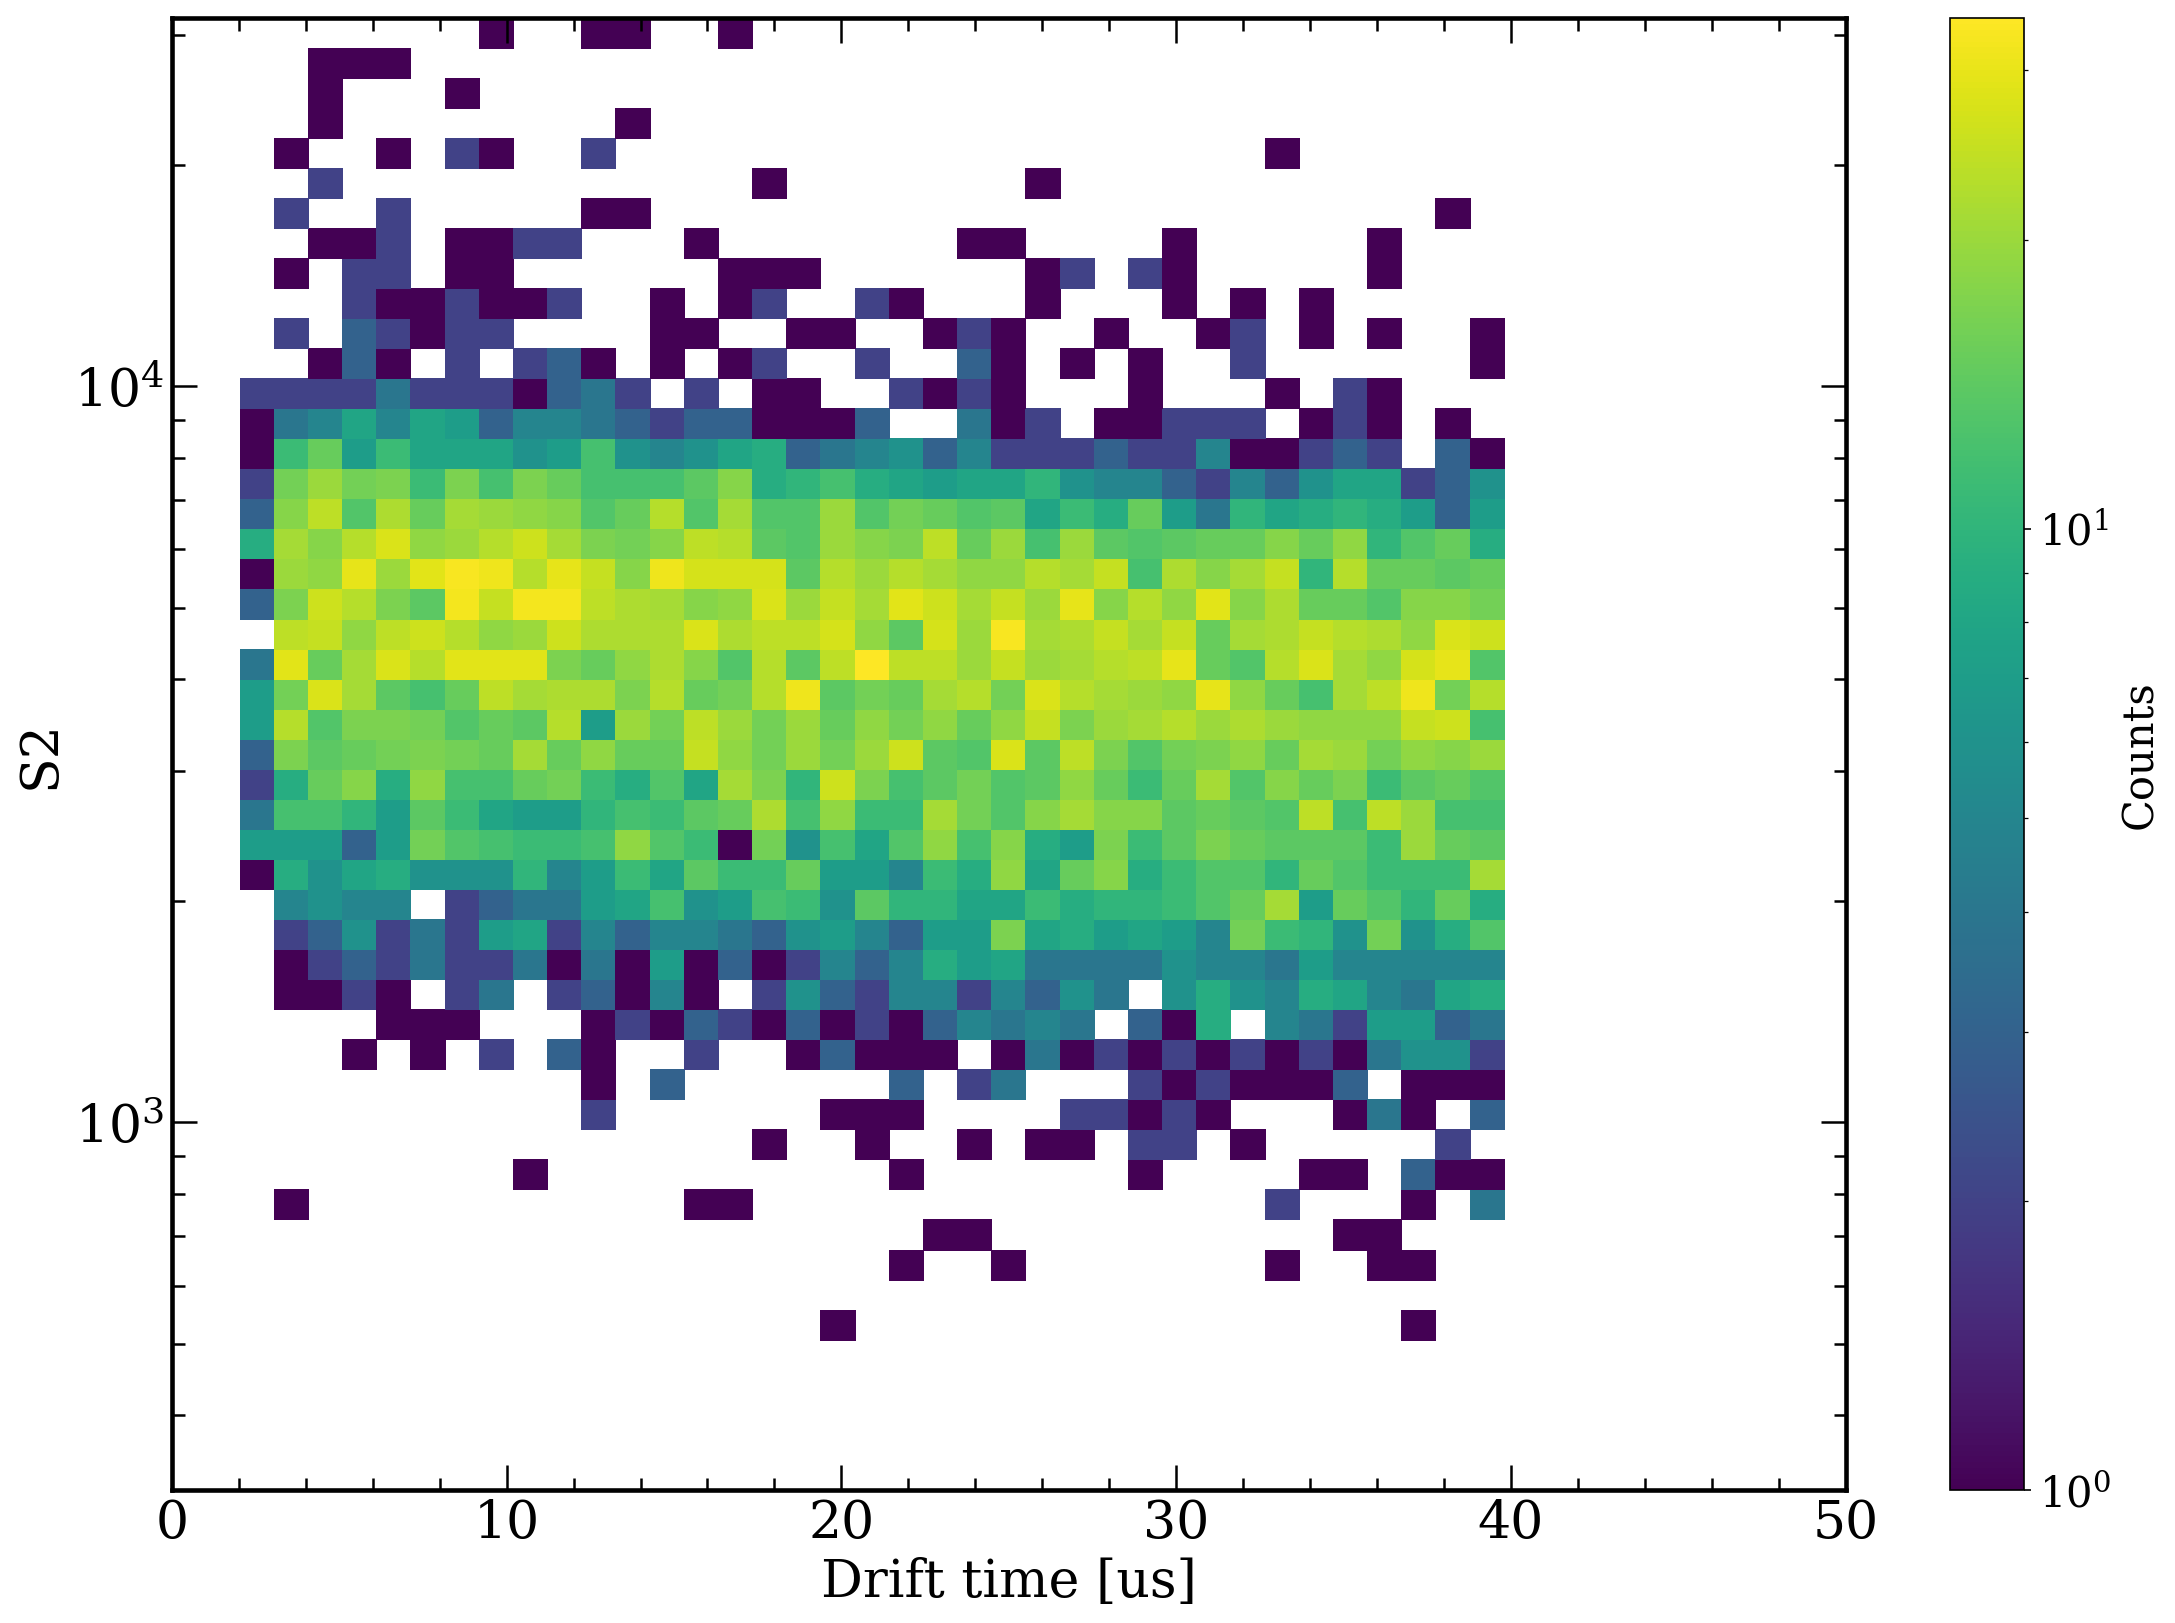

In [86]:
fig, axes = ps.styles()





drifttime = np.array(drifttime)


bins_x = np.linspace(0,50,50)
bins_y = np.logspace(2.5,4.5,50)
counts, xedges, yedges = np.histogram2d(drifttime/1e3, s2, bins=(bins_x, bins_y))
xcenter = ((xedges[:-1]+xedges[1:])/2)
ycenter = ((yedges[:-1]+yedges[1:])/2)

poisson_list = []

for i in counts:
    error_per_slice = []
    for j in i:
        a =poisson_interval(j)[1]
        error_per_slice.append(a)
    poisson_list.append(error_per_slice)
    

    
im = axes.pcolormesh(bins_x, bins_y, counts.T, cmap='viridis', norm=mcolors.LogNorm())
axes.set_yscale('log')
axes.set_xlabel('Drift time [us]')
axes.set_ylabel('S2')
cbar = plt.colorbar(im, ax=axes)
cbar.set_label('Counts',size=20)
cbar.ax.tick_params(labelsize=20) 
plt.show()

## 3.2 Fit each slice of the histogram

No handles with labels found to put in legend.


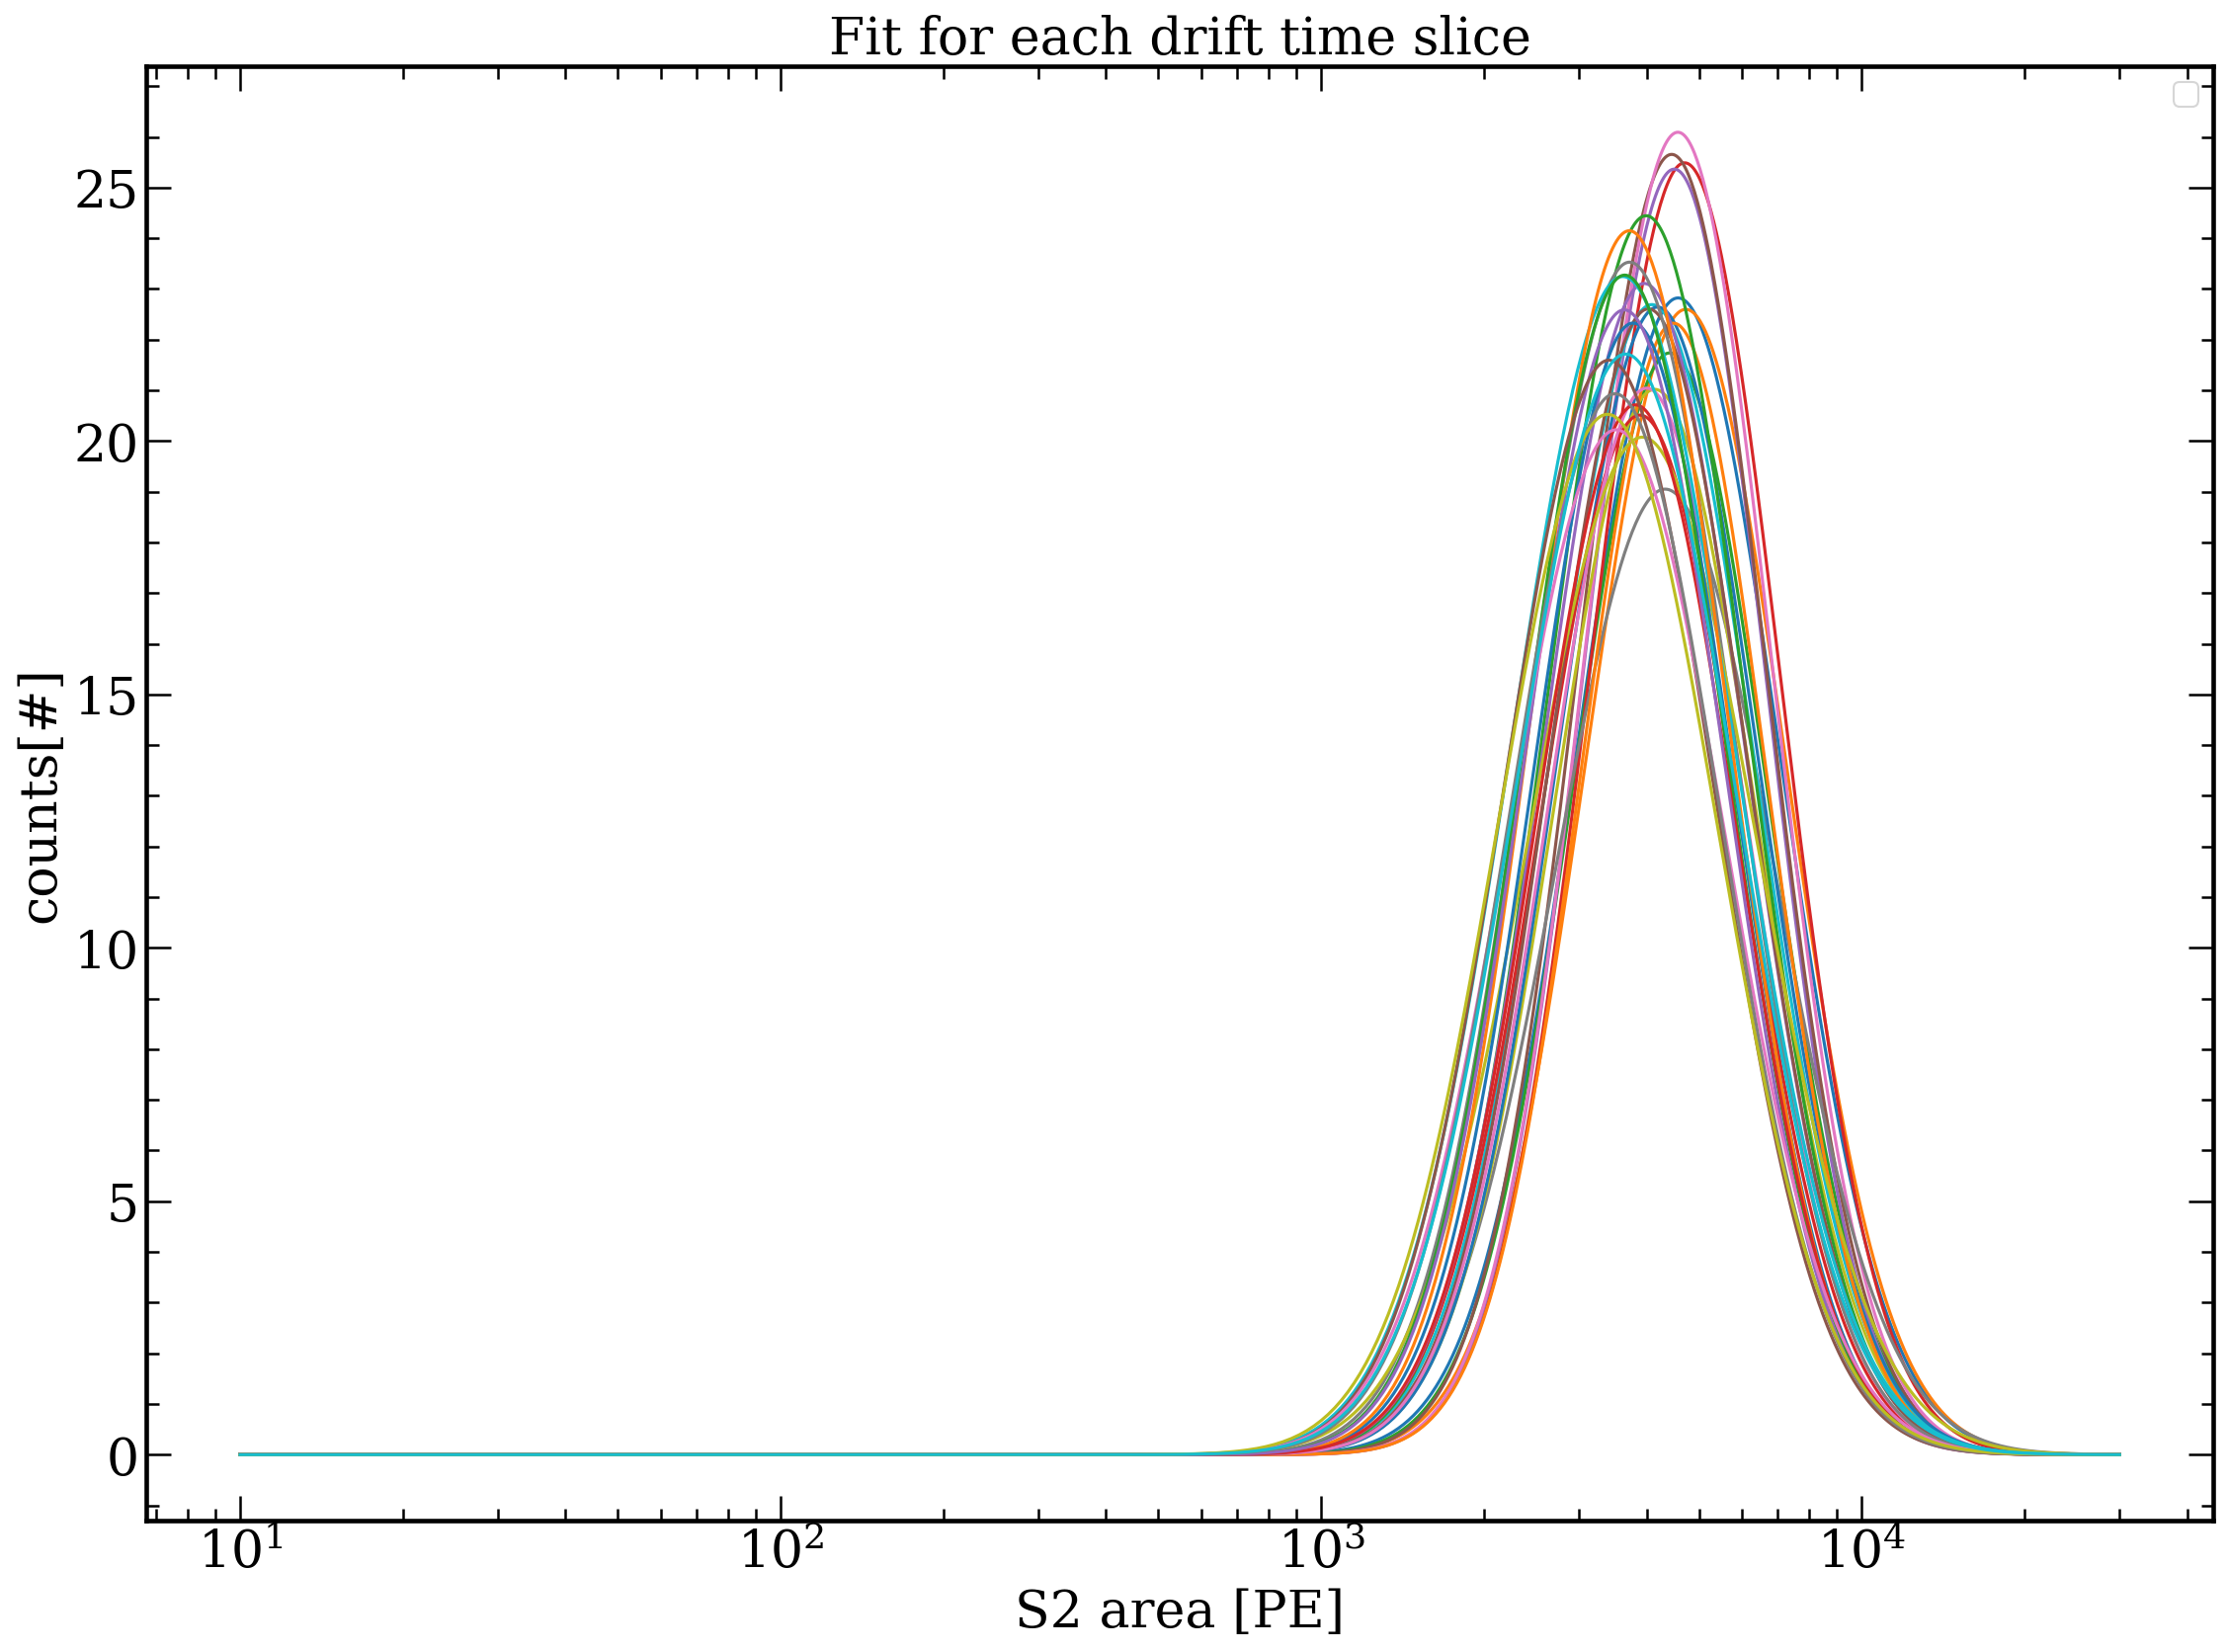

In [87]:
fig, axes = ps.styles()
fit_range= np.linspace(10,30000,1000)


p0 = [50,8,2]


#########This for a random slice ###########
# popt, pcov = curve_fit(log_gaus, ycenter, counts[27], p0)
# plt.scatter(ycenter, counts[27], c = 'r', marker = 'x')
# plt.plot(fit_range, log_gaus(fit_range, *popt))
#############################################


axes.set_xscale('log')
axes.set_title('Fit for each drift time slice')
axes.set_xlabel('S2 area [PE]')
axes.set_ylabel('counts[#]')



expectation_list = []
error_list = []




for i in range(5,35):   
    popt, pcov = curve_fit(log_fit, ycenter, counts[i], p0,sigma = poisson_list[i], absolute_sigma = True, maxfev = 10000)
    perr = np.sqrt(np.diag(pcov))
    plt.plot(fit_range, log_fit(fit_range, *popt))
    expectation = np.exp(popt[1]-popt[2]**2)
    expectation_list.append(expectation)
    diff_mu = expectation
    diff_sigma = expectation * 2 * popt[2]
    error_mu = perr[1]
    error_sigma = perr[2] 
    error = np.sqrt(diff_mu**2 * error_mu**2 + diff_sigma**2 * error_sigma**2)
    error_list.append(error)
    
#     expectation = np.exp(popt[1]+((popt[2]**2)/2))
#     expectation_list.append(expectation)
#     diff_mu = expectation
#     diff_sigma = expectation*popt[2]
#     error_mu = perr[1]
#     error_sigma = perr[2] 
#     error = np.sqrt(diff_mu**2 * error_mu**2 + diff_sigma**2 * error_sigma**2)
#     error_list.append(error)
axes.legend(loc = 1, prop={'size': 15})
plt.show()

## 3.3 Extract the electron lifetime

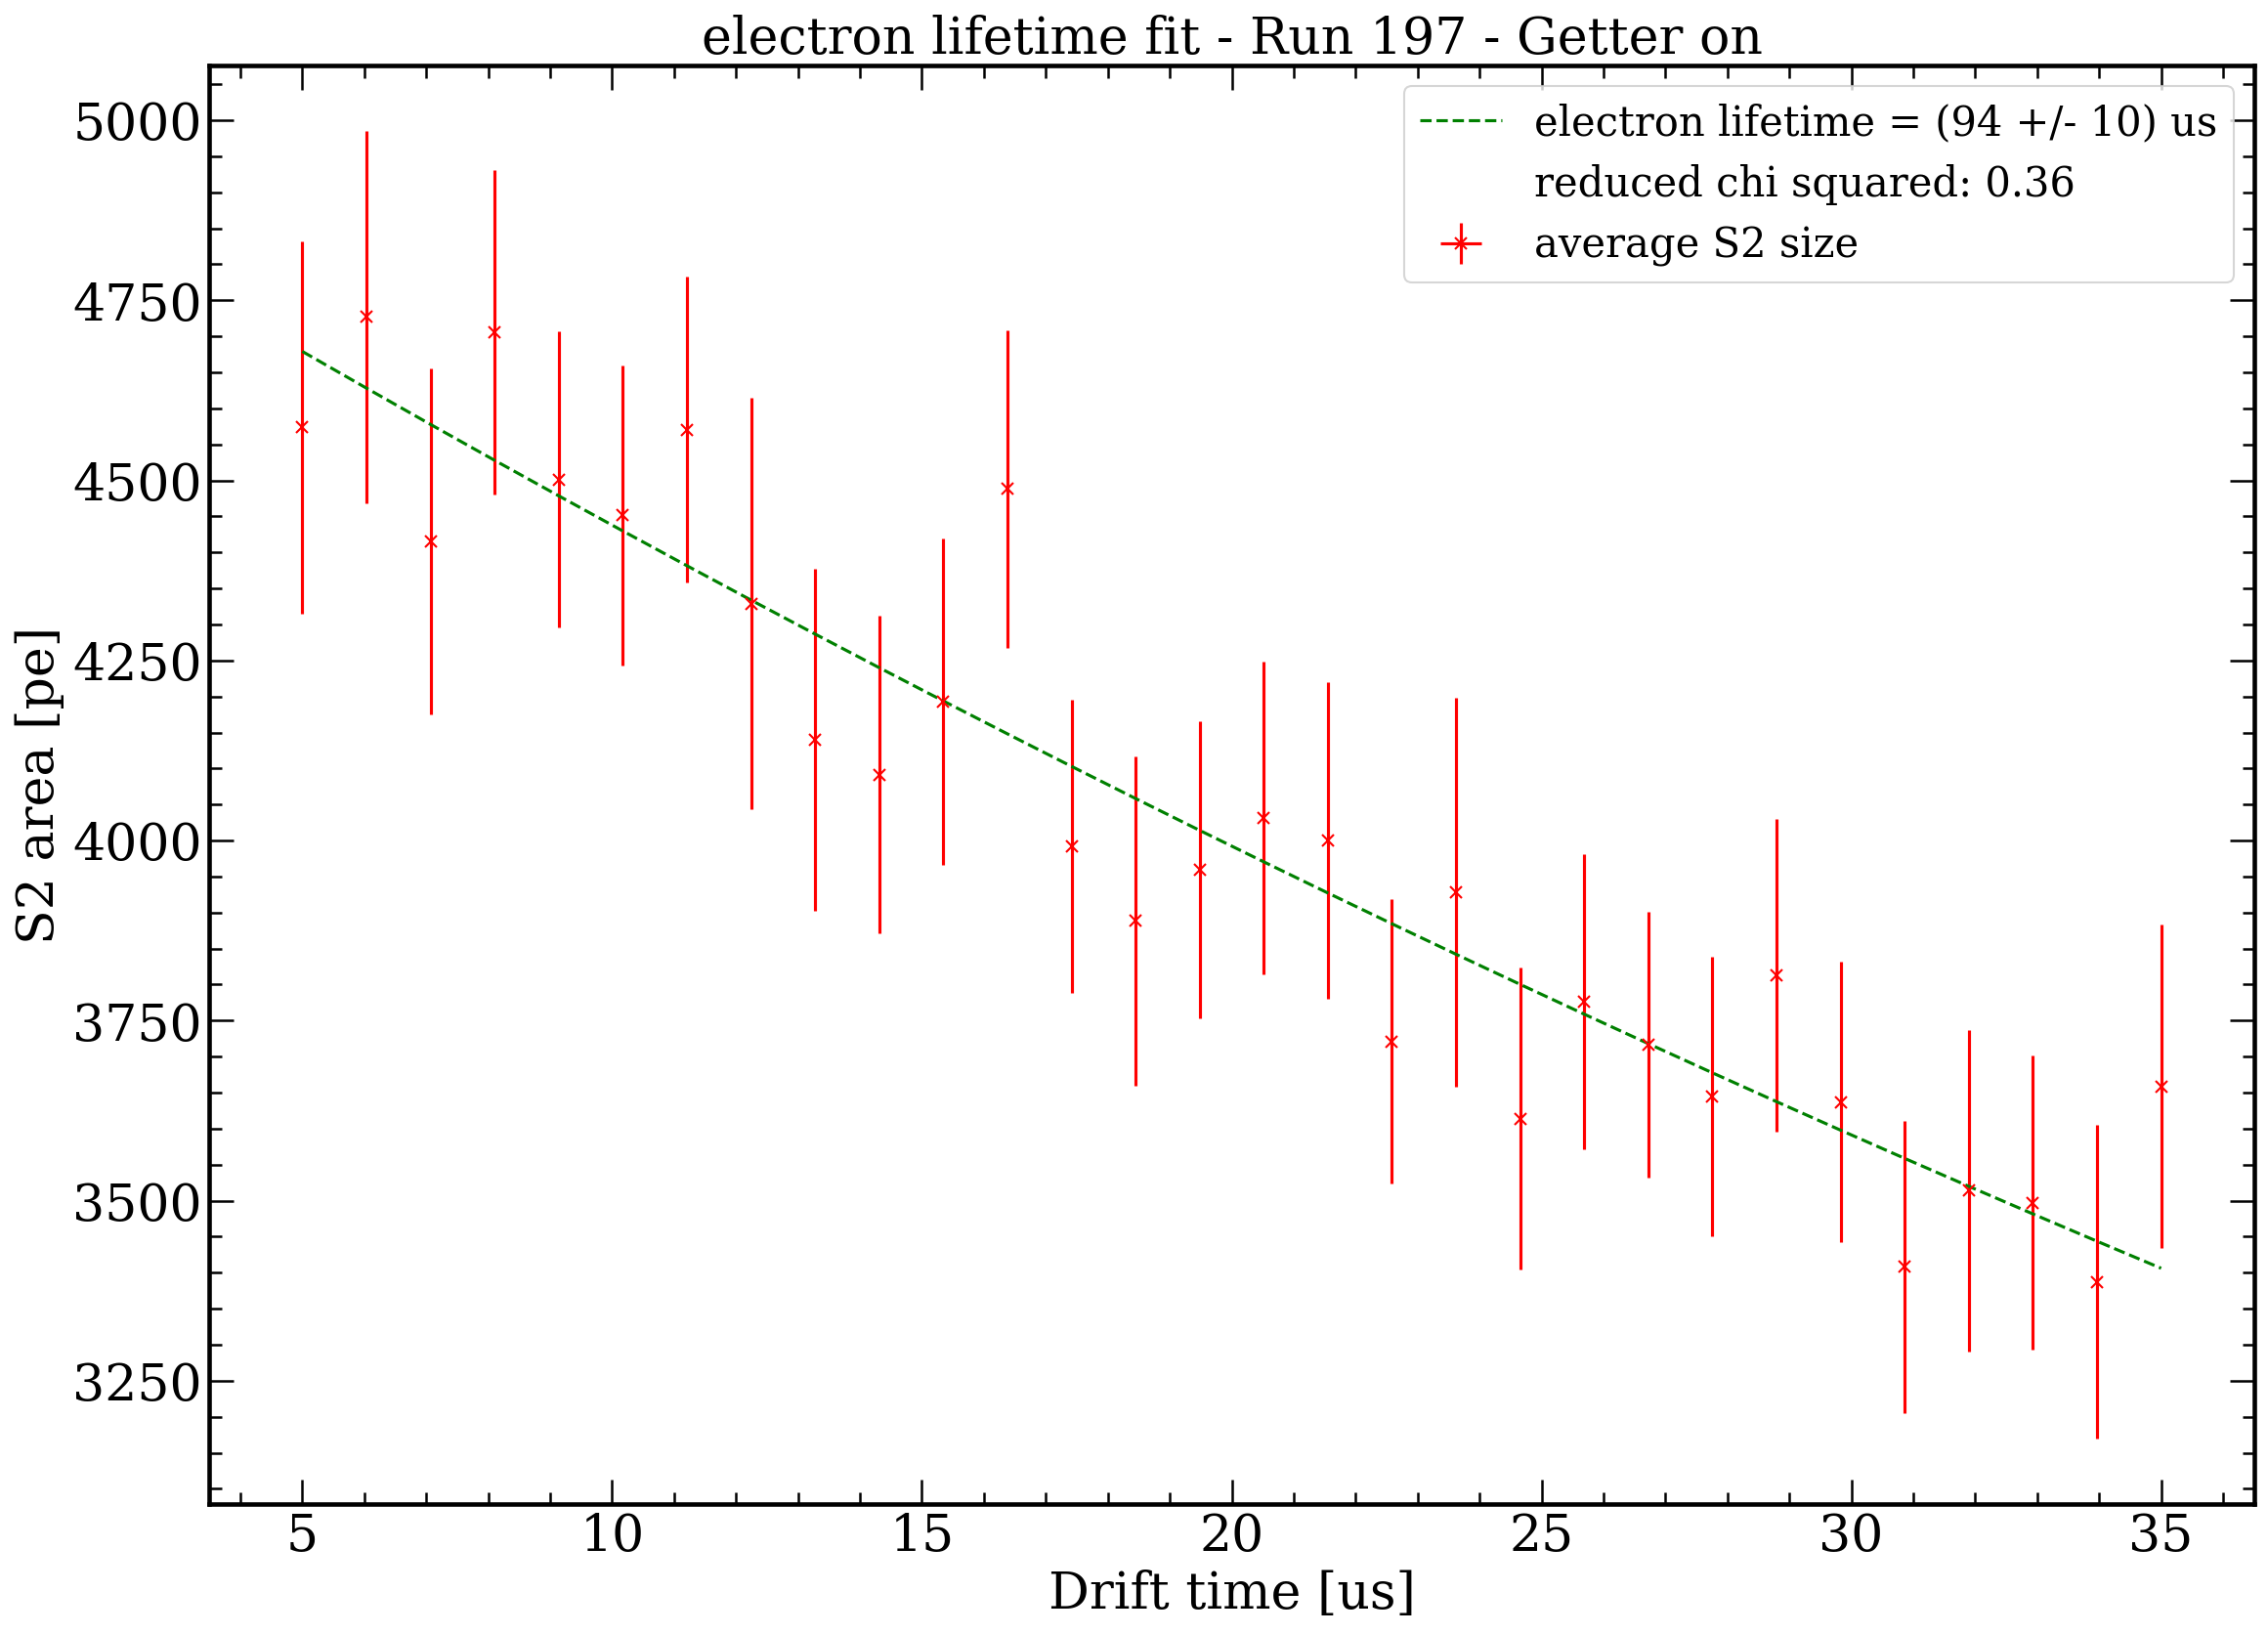

this is lamba:  0.010583043151285545
this is 1/lamba:  94.49077979791926
electron lifetime:  94 +/- 10


In [88]:
fig, axes = ps.styles()

p0=  [10000,0.1]
x = np.linspace(5,35,30)



popt, pcov = curve_fit(expo, x, expectation_list, sigma=error_list, p0=p0, absolute_sigma=True, maxfev= 10000)
perr = np.sqrt(np.diag(pcov))

lifetime = f"{(1/popt[1]):.0f}"
lifetime_error =f"{((1/(popt[1]**2))*perr[1]):.0f}"



chi_squared =  (np.sum((expectation_list - expo(x, *popt))**2 / np.array(error_list)**2))
Reduced_chi_squared ="%.2f" %( chi_squared / len(x))


axes.errorbar(x, expectation_list, yerr=error_list, xerr=0, fmt = 'rx', label = 'average S2 size' )
axes.plot(x, expo(x, *popt), 'g--', label = 'electron lifetime = ('+lifetime+ ' +/- '+lifetime_error+') us')
axes.plot([], [], ' ', label="reduced chi squared: "+Reduced_chi_squared)


# axes.set_xlim([0,40])
# axes.set_ylim([8000,11000])
axes.set_title('electron lifetime fit - Run '+run[2:]+' - Getter on')
axes.set_xlabel('Drift time [us]')
axes.set_ylabel('S2 area [pe]')
axes.legend(prop={'size': 20})
plt.show()

print('this is lamba: ', popt[1])
print('this is 1/lamba: ', 1/popt[1] )
print('electron lifetime: ', lifetime, '+/-', lifetime_error)

## 3.4 Average s2 size (uncorrected)

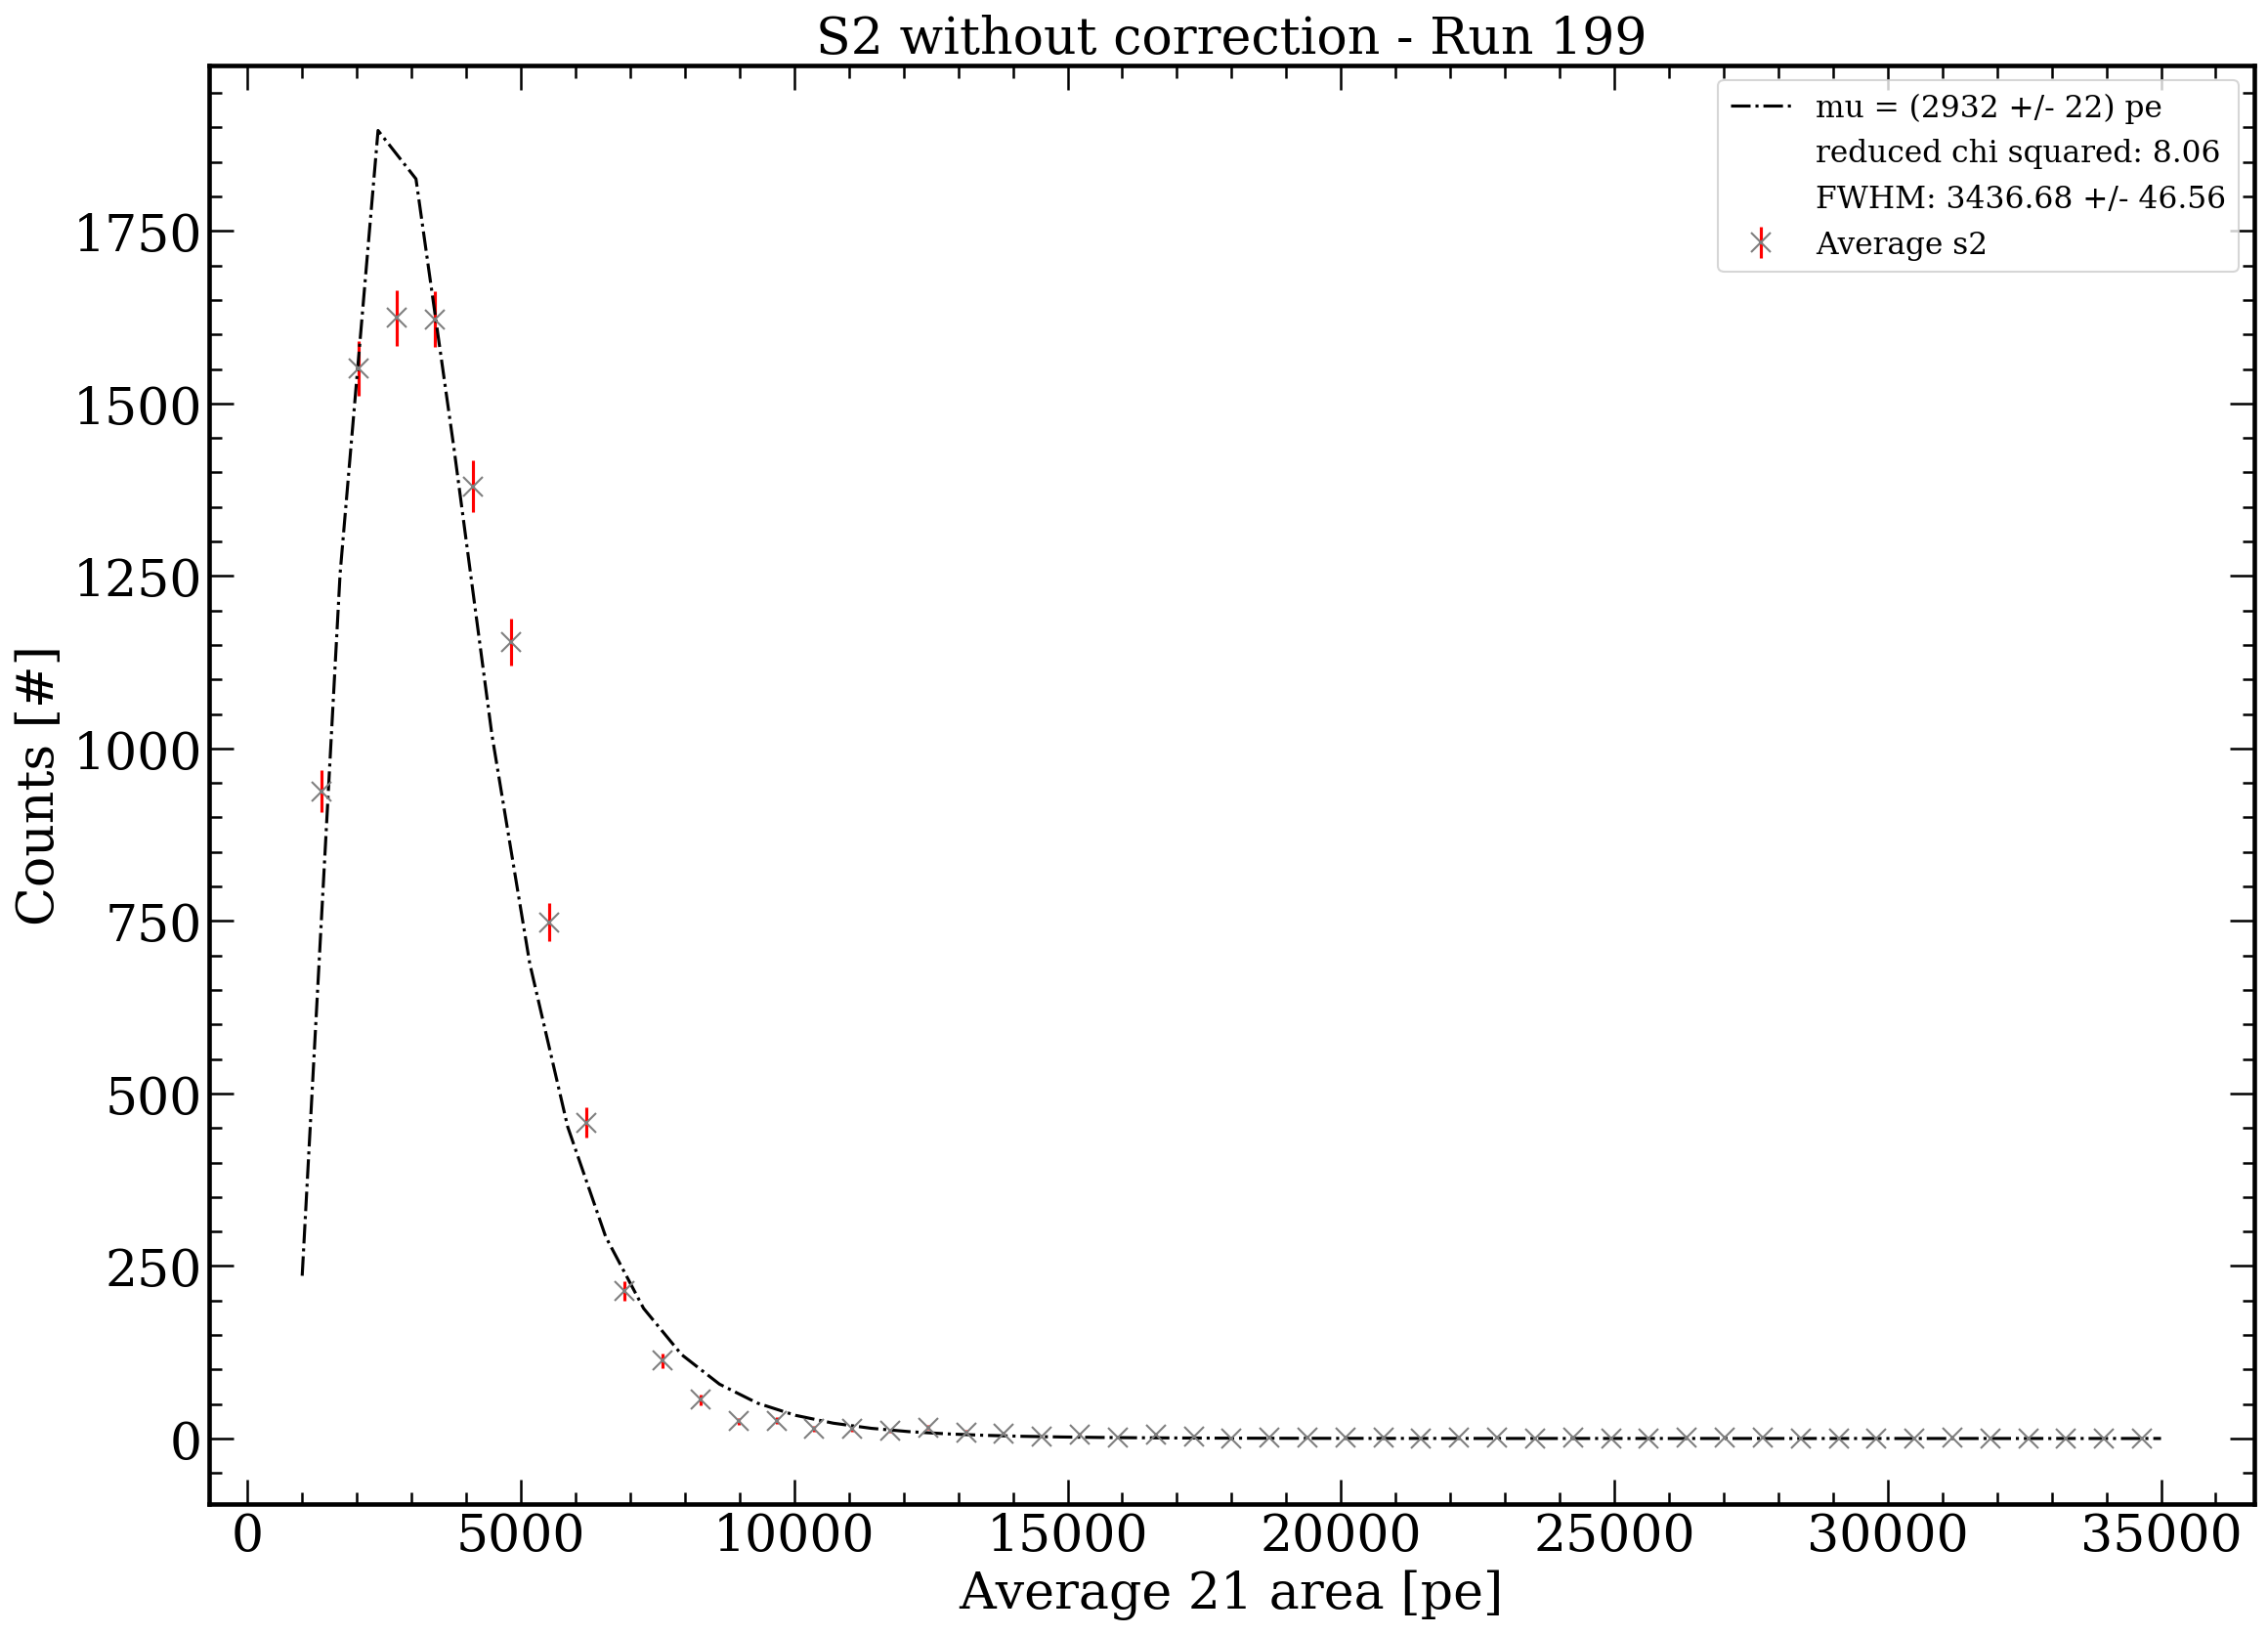

In [14]:
fig, axes = ps.styles()
poisson_list = []
p0_log = [10,10,10]
#p0 = [200,12000,200]
x_range = np.linspace(1000, 35000,50)
counts, binEdges = np.histogram(s2, bins=x_range)
for i in counts:
    a= poisson_interval(i)[1]
    poisson_list.append(a)

bincenters= 0.5 * (binEdges[1:] + binEdges[:-1])
popt, pcov = curve_fit(log_gaus, bincenters, counts, p0_log,  sigma = poisson_list, absolute_sigma = True, maxfev = 10000)
perr = np.sqrt(np.diag(pcov))




expectation = np.exp(popt[1]+((popt[2]**2)/2))
diff_mu = expectation
diff_sigma = expectation*popt[2]
error_mu = perr[1]
error_sigma = perr[2]   
error = np.sqrt(diff_mu**2 * error_mu**2 + diff_sigma**2 * error_sigma**2)

s2_mu = f"{expectation:.0f}"
s2_error = f"{error:.0f}"

# s2_mu = f"{popt[1]:.1f}"

# s2_error = f"{perr[1]:.1f}"



# S2_mu = np.exp(popt[1]+((popt[2]**2)/2))
# S2_mu_str = "%.2f" % S2_mu
# S2_mu = popt[1]
# S2_mu_str = "%.2f" % S2_mu

S2_sigma = np.exp(popt[1]+((popt[2]**2)/2))    * np.sqrt(np.exp(popt[2]**2)-1)
FWHM_diff_mu = S2_sigma
FWHM_diff_sigma = expectation * popt[2] * (np.sqrt(np.exp(popt[2]**2)-1)+1/(np.sqrt(np.exp(popt[2]**2)-1))*np.exp(popt[2]**2)) 
S2_sigma_error = np.sqrt(FWHM_diff_mu**2 *error_mu**2 + FWHM_diff_sigma**2 * error_sigma**2 )
FWHM ="%.2f" % (2* np.sqrt(2*np.log(2))* S2_sigma)
FWHM_error = "%.2f" % (2* np.sqrt(2*np.log(2))*S2_sigma_error)

xdata=bincenters[1:-1]
ydata=counts[1:-1]
chi_squared =  (np.sum((counts - log_gaus(bincenters, *popt))**2 / np.array(poisson_list)**2))
Reduced_chi_squared ="%.2f" %( chi_squared / len(xdata))

plt.errorbar(bincenters, counts, yerr=np.sqrt(counts), marker = 'x', fmt='.',c = 'C7',markersize='10', ecolor='red', label='Average s2')
axes.plot(x_range,log_gaus(x_range,*popt), color = 'k', linestyle = '-.', label = 'mu = ('+s2_mu+ ' +/- '+s2_error+') pe')
#axes.plot([], [], ' ', label="Drift field: 6kV/cm")
axes.plot([], [], ' ', label="reduced chi squared: "+Reduced_chi_squared)
axes.plot([], [], ' ', label="FWHM: "+FWHM +' +/- '+ FWHM_error)
axes.set_title('S2 without correction - Run '+run[2:])
axes.set_ylabel('Counts [#]')
axes.set_xlabel('Average 21 area [pe]')
axes.legend(loc = 1, prop={'size': 15})
plt.show()

## 3.5 Average s2 size (corrected)

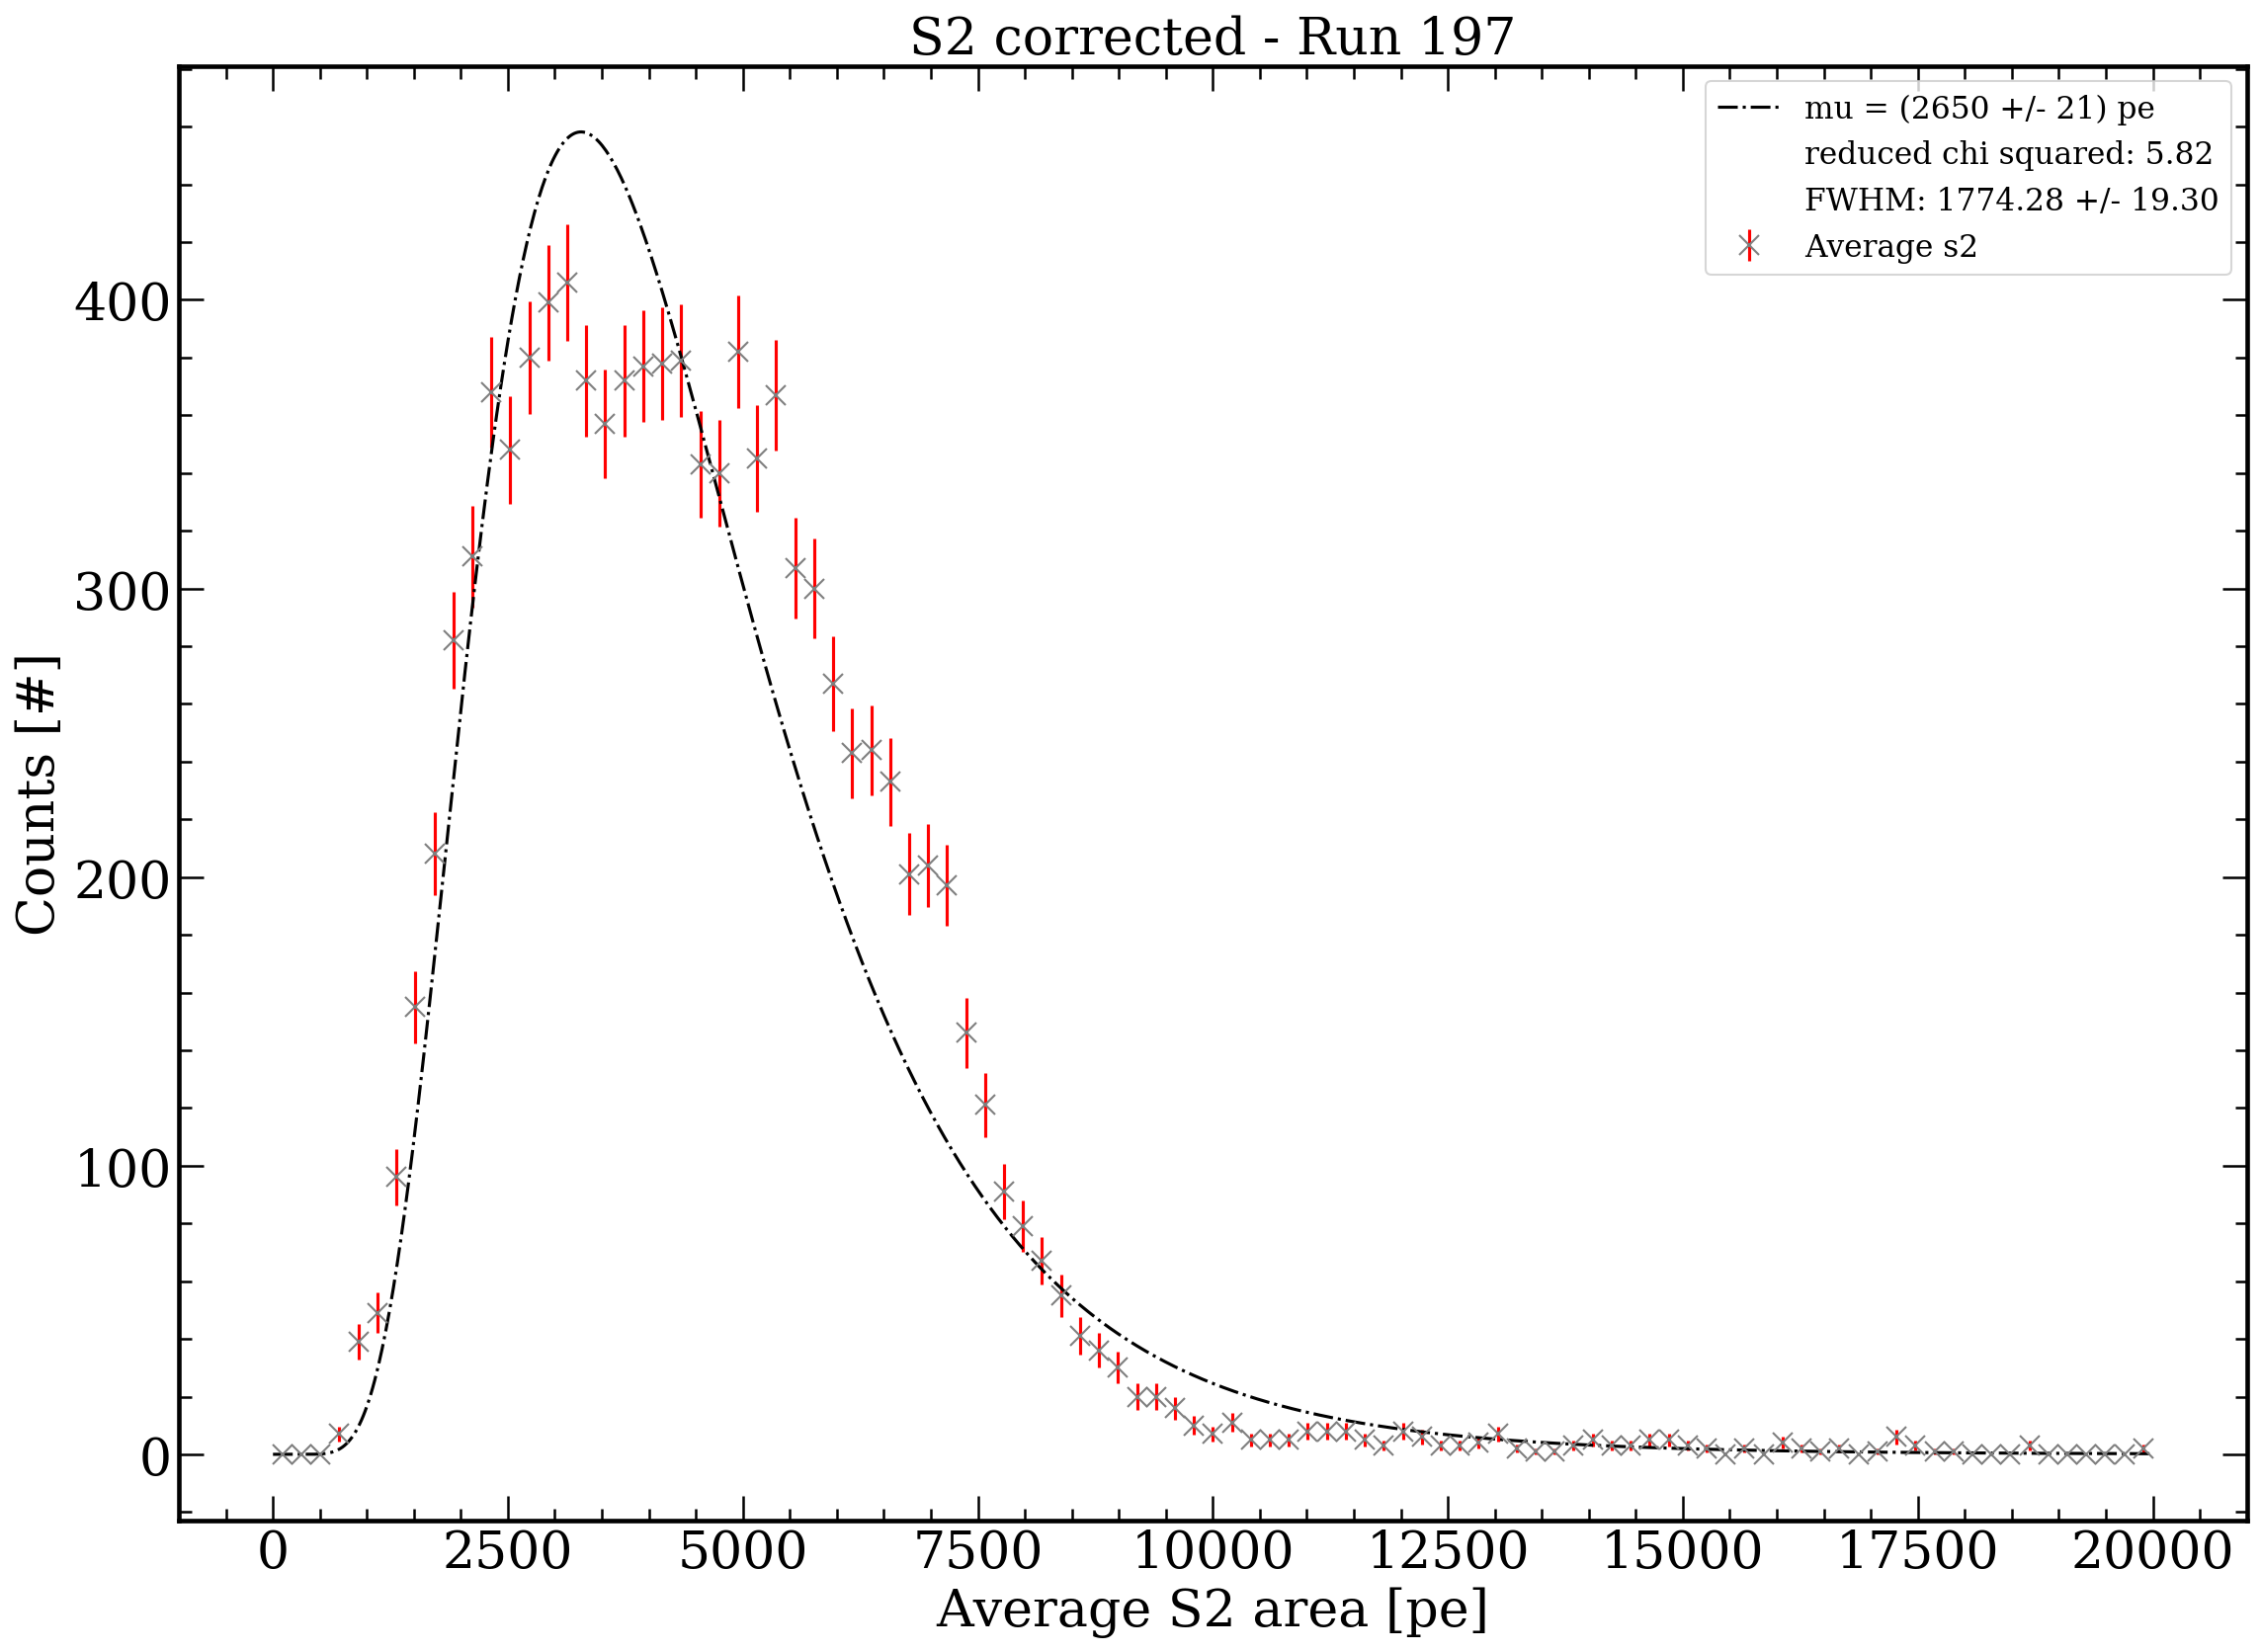

In [90]:
fig, axes = ps.styles()
poisson_list = []
p0 = [10,10,10]
#p0 = [200,12000,200]
x_range = np.linspace(1, 20000,1000)
counts, binEdges = np.histogram(cs2, bins=np.linspace(1,20000,100))
for i in counts:
    q= poisson_interval(i)[1]
    poisson_list.append(q)

bincenters= 0.5 * (binEdges[1:] + binEdges[:-1])
popt, pcov = curve_fit(log_gaus, bincenters, counts, p0,  sigma = poisson_list, absolute_sigma = True, maxfev = 10000)
perr = np.sqrt(np.diag(pcov))



expectation = np.exp(popt[1]-popt[2]**2)
diff_mu = expectation
diff_sigma = expectation * 2 * popt[2]
error_mu = perr[1]
error_sigma = perr[2] 
error = np.sqrt(diff_mu**2 * error_mu**2 + diff_sigma**2 * error_sigma**2)

# expectation = np.exp(popt[1]+((popt[2]**2)/2))
# diff_mu = expectation
# diff_sigma = expectation*popt[2]
# error_mu = perr[1]
# error_sigma = perr[2]   
# error = np.sqrt(diff_mu**2 * error_mu**2 + diff_sigma**2 * error_sigma**2)

s2_mu = f"{expectation:.0f}"
s2_error = f"{error:.0f}"




S2_sigma = np.exp(popt[1]+((popt[2]**2)/2))    * np.sqrt(np.exp(popt[2]**2)-1)
FWHM_diff_mu = S2_sigma
FWHM_diff_sigma = expectation * popt[2] * (np.sqrt(np.exp(popt[2]**2)-1)+1/(np.sqrt(np.exp(popt[2]**2)-1))*np.exp(popt[2]**2)) 
S2_sigma_error = np.sqrt(FWHM_diff_mu**2 *error_mu**2 + FWHM_diff_sigma**2 * error_sigma**2 )
S2_sigma = "%.2f" % S2_sigma
S2_sigma_error = "%.2f" % S2_sigma_error

# FWHM ="%.2f" % (2* np.sqrt(2*np.log(2))* S2_sigma)
# FWHM_error = "%.2f" % (2* np.sqrt(2*np.log(2))*S2_sigma_error)

xdata=bincenters[1:-1]
ydata=counts[1:-1]
chi_squared =  (np.sum((counts - log_gaus(bincenters, *popt))**2 / np.array(poisson_list)**2))
Reduced_chi_squared ="%.2f" %( chi_squared / len(xdata))

plt.errorbar(bincenters, counts, yerr=np.sqrt(counts), marker = 'x', fmt='.',c = 'C7',markersize='10', ecolor='red', label='Average s2')
axes.plot(x_range,log_gaus(x_range,*popt), color = 'k', linestyle = '-.', label = 'mu = ('+s2_mu+ ' +/- '+s2_error+') pe')
#axes.plot([], [], ' ', label="Drift field: 6kV/cm")
axes.plot([], [], ' ', label="reduced chi squared: "+Reduced_chi_squared)
axes.plot([], [], ' ', label="FWHM: "+S2_sigma +' +/- '+ S2_sigma_error)
axes.set_title('S2 corrected - Run '+run[2:])
axes.set_ylabel('Counts [#]')
axes.set_xlabel('Average S2 area [pe]')
axes.legend(loc = 1, prop={'size': 15})
plt.show()

In [16]:
expectation = np.exp(popt[1]-popt[2]**2)
print(expectation)

3277.9846224908947


In [17]:
print(popt[0])

1930503.1031494683


In [18]:
print(np.exp(popt[1]))

4054.44030440262


In [19]:
print(len(s2))
print(len(z))
print(len(cs2))

10166
10166
10166


## 3.6 Correction along the TPC (before)

No handles with labels found to put in legend.


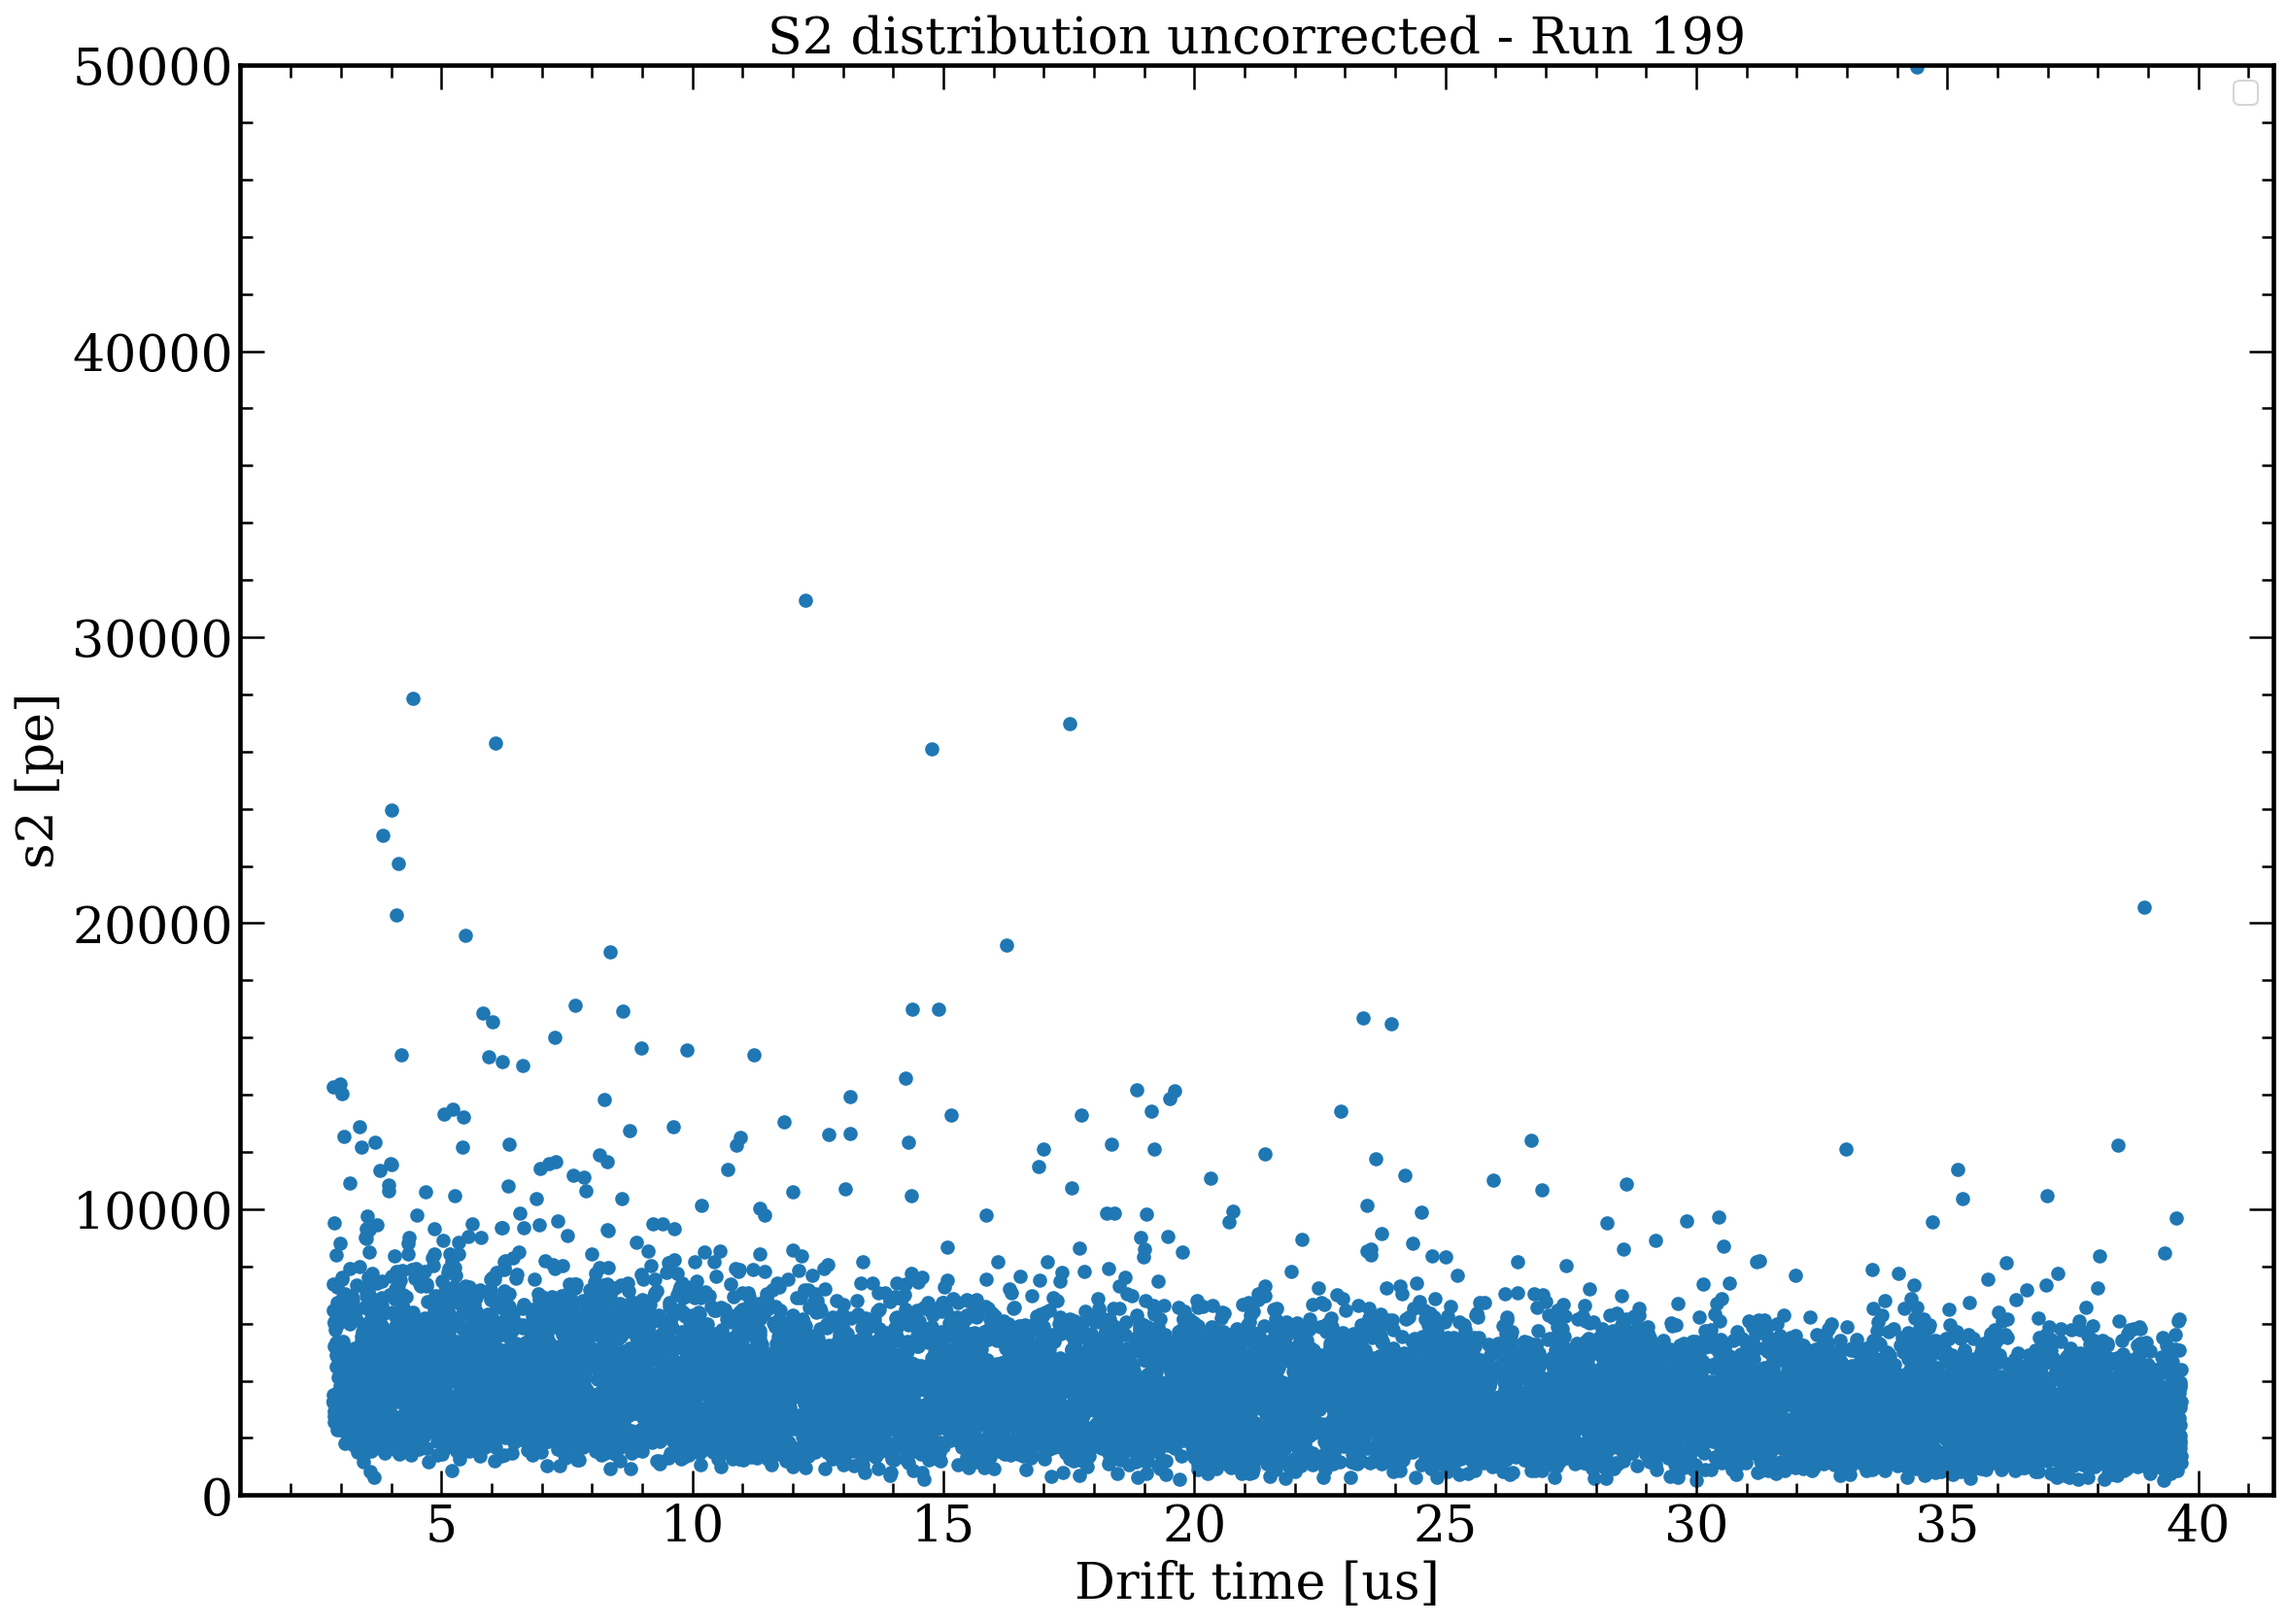

In [20]:
fig, axes = ps.styles()

def linear(x,m,c):
    fit = m * x + c
    return fit


p0 = [11, 12500]
x = np.linspace(-70,-5,66)



z = np.array(z)
s2 = np.array(s2)
cs2 = np.array(cs2)
drifttime = np.array(drifttime)
def expo(x, a, b):
    return a*np.exp(-b*x)

p1=  [100,1]

#popt, pcov = curve_fit(expo, drifttime/1e3, s2, p0=p1, maxfev= 10000)

# axes.plot(drifttime,expo(drifttime,*popt), color = 'k', linestyle = '-.')
axes.scatter(drifttime/1e3, s2)
# axes.set_xlim([6000,20000])
axes.set_ylim([0,50000])
axes.set_title('S2 distribution uncorrected - Run '+run[2:])
axes.set_ylabel('s2 [pe]')
axes.set_xlabel('Drift time [us]')
axes.legend(loc = 1, prop={'size': 15})
plt.show()

## 3.7 Correction along the TPC (after)

No handles with labels found to put in legend.


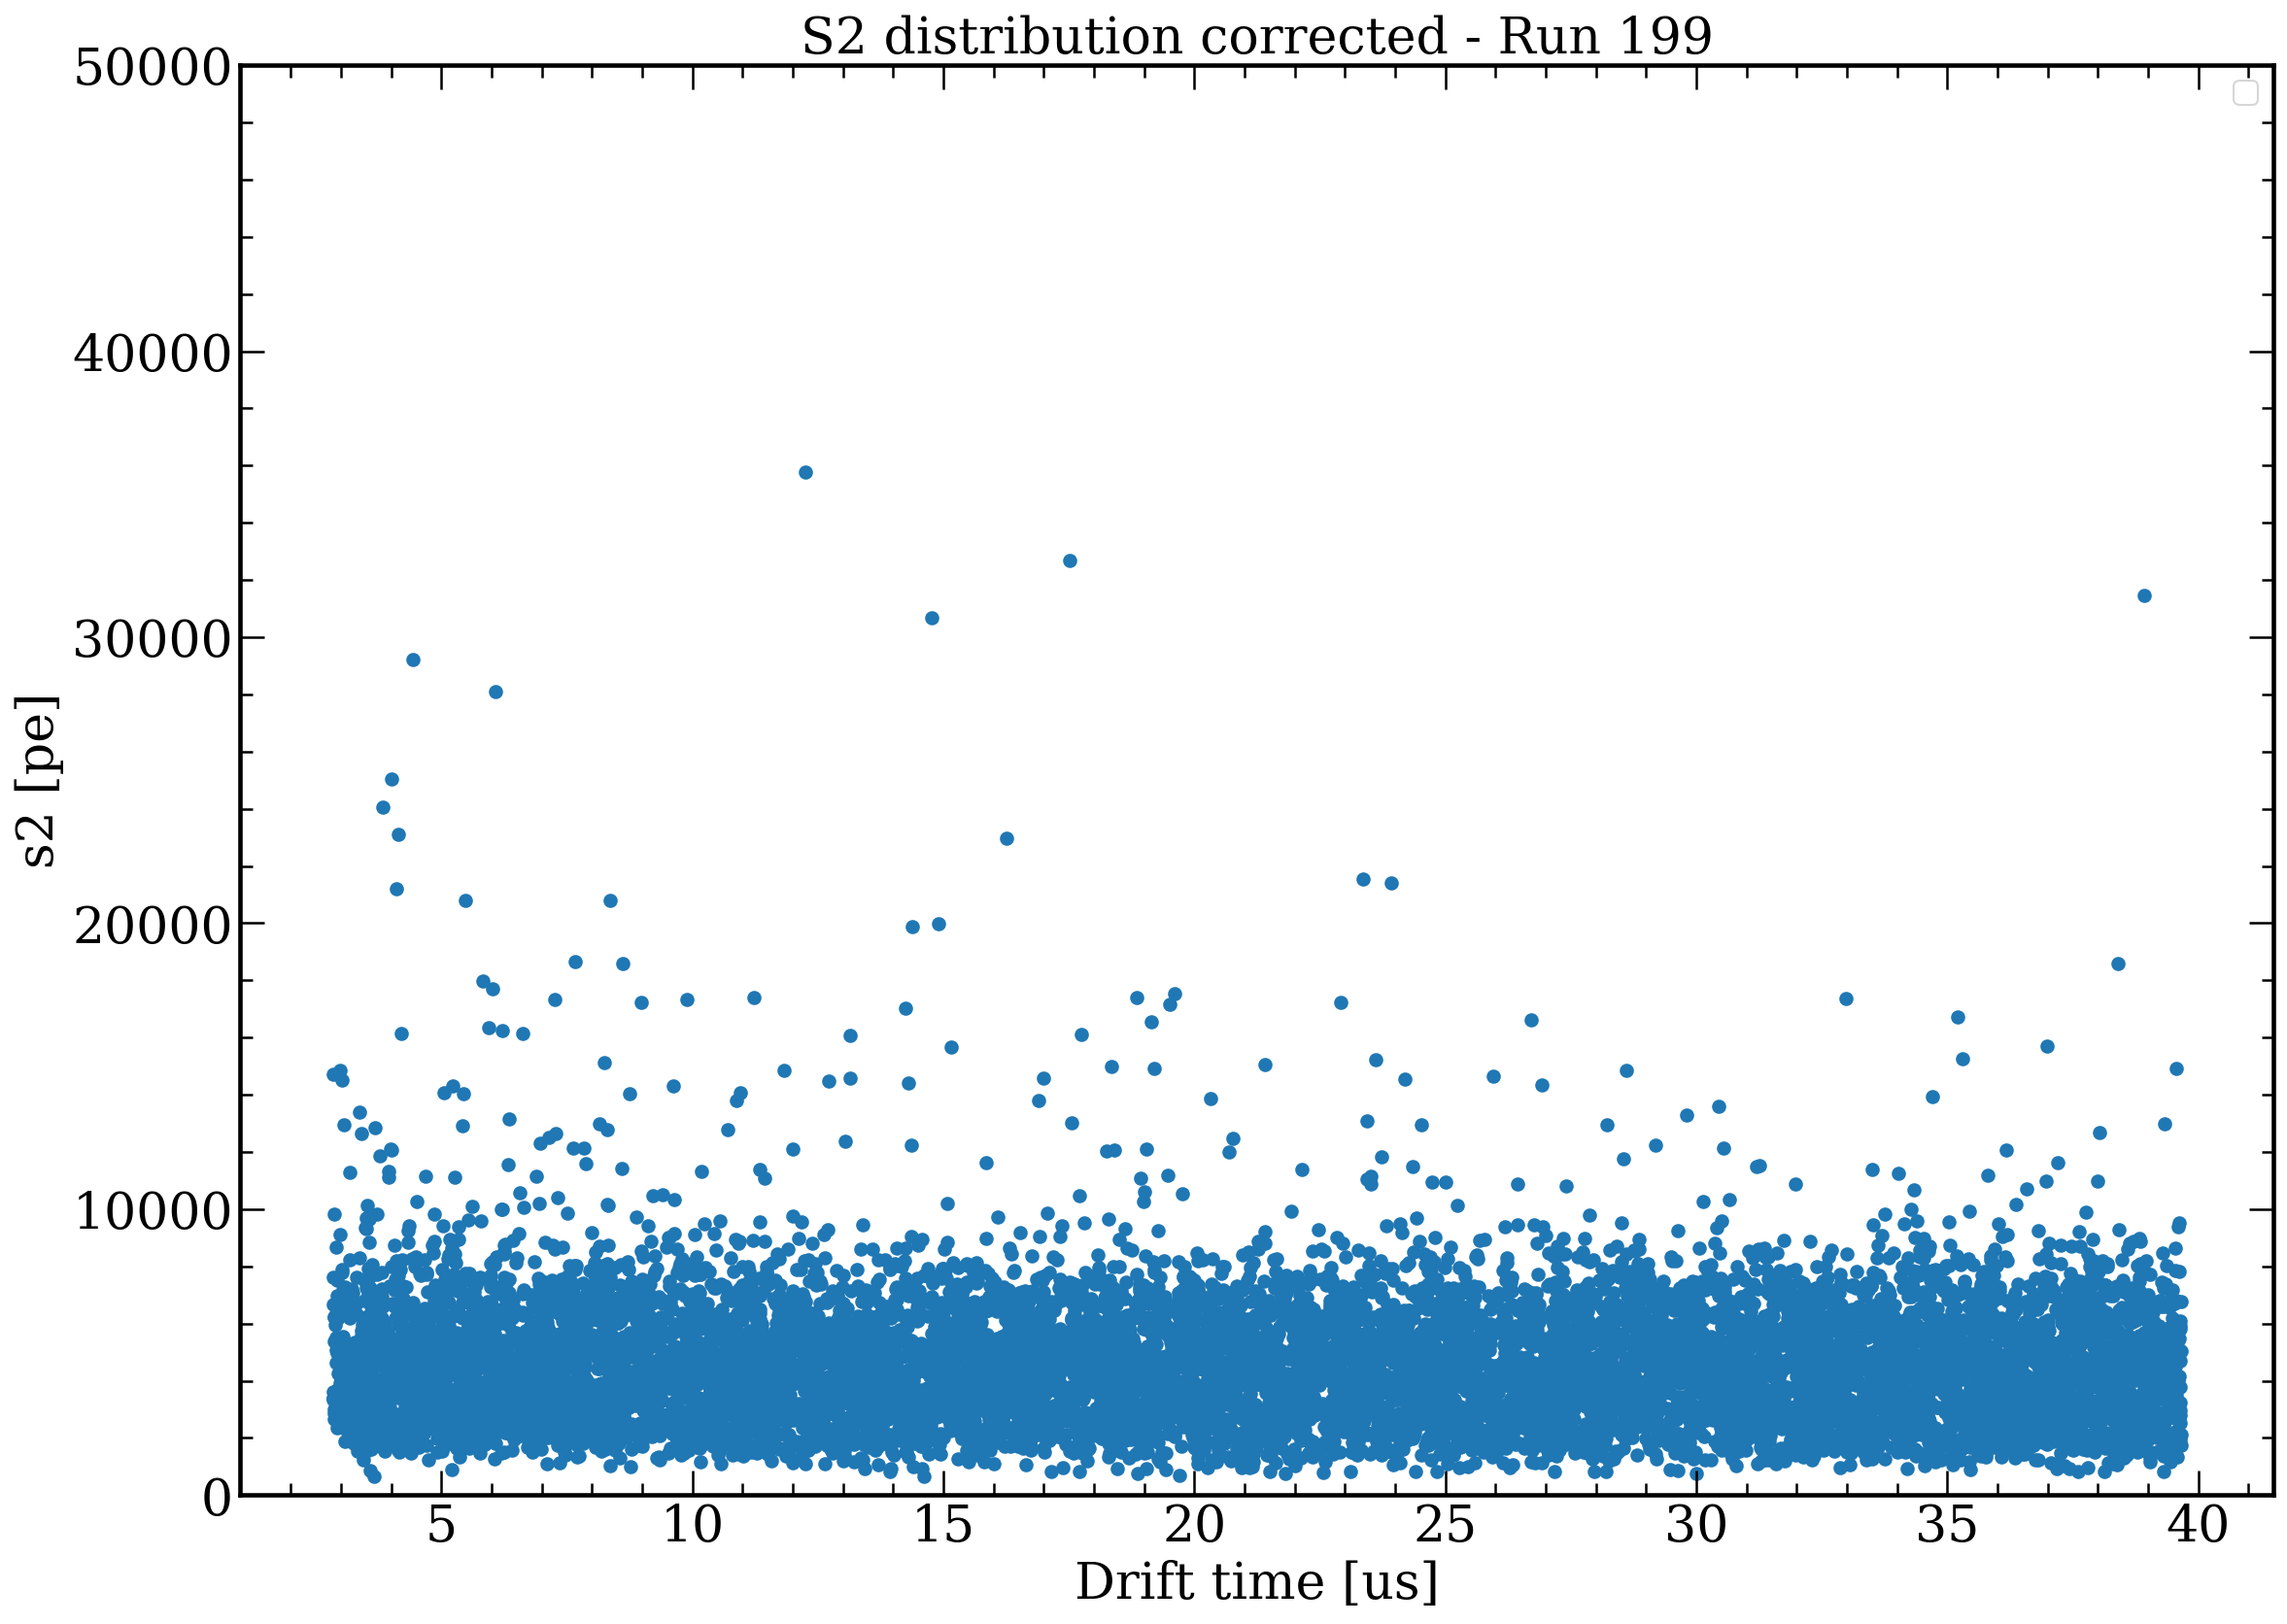

In [21]:
fig, axes = ps.styles()

def linear(x,m,c):
    fit = m * x + c
    return fit



def expo(x, a, b):
    return a*np.exp(-b*x)



#popt, pcov = curve_fit(expo, drifttime/1e3, s2, p0=p1, maxfev= 10000)

# axes.plot(drifttime,expo(drifttime,*popt), color = 'k', linestyle = '-.')
axes.scatter(drifttime/1e3, cs2)
# axes.set_xlim([6000,20000])
axes.set_ylim([0,50000])
axes.set_title('S2 distribution corrected - Run '+run[2:])
axes.set_ylabel('s2 [pe]')
axes.set_xlabel('Drift time [us]')
axes.legend(loc = 1, prop={'size': 15})
plt.show()

In [22]:
# random_list = []


# def drifttime_to_z(t):
#     return a * t + b


# def CutCondition(waveform):  
#     FirstPeak_area = sum(waveform[:15])
#     SecondPeak_area = sum(waveform[15:])
#     FirstPeak_maximum = max(waveform[:15])
#     SecondPeak_maximum = max(waveform[15:])
#     SecondPeak_index = np.where(waveform == SecondPeak_maximum)
#     SecondPeak_index_left = SecondPeak_index[0][0] -1
#     SecondPeak_index_right = SecondPeak_index[0][0] +1
#     SecondPeak_maximum_left = waveform[SecondPeak_index_left]
#     SecondPeak_maximum_right = waveform[SecondPeak_index_right]

    
    
    
#     if  FirstPeak_area > 100 and FirstPeak_area < 500 and SecondPeak_area > 40 and SecondPeak_area  < 200 \
#     and SecondPeak_maximum < 0.5 * FirstPeak_maximum \
#     and SecondPeak_maximum > 0.25 * FirstPeak_maximum \
#     and SecondPeak_maximum > waveform[SecondPeak_index_left] \
#     and SecondPeak_maximum > waveform[SecondPeak_index_right] \
#     : 
#         return(True)
#     else:
#         return(False)
    

# def PrintWaveform(waveform,i):
    
#     fig, ax1 = plt.subplots(sharex=False, figsize=(12, 3.5))
#     ax1.plot(waveform[i])
#     plt.show()

# def Process_S2(waveform, i): 
#     SelectionCutFlag = CutCondition(waveform[i])
#     if SelectionCutFlag == True:

#         j = 1
#         counter_timestamp = timestamp[i+j]
#         threshold_timestamp = timestamp[i] + 45000
#         while threshold_timestamp >= counter_timestamp and  S2_found(integral = integral[i+j], width = width[i+j]) == False:  
#             j += 1
#             counter_timestamp = timestamp[i+j]
#         else:
#             if S2_found(integral = integral[i+j], width = width[i+j]):

#                 k=1 
#                 s2_counter_timestamp = timestamp[i+j+k]
#                 z_position = drifttime_to_z(timestamp[i+j] - timestamp[i])
#                 while threshold_timestamp >= s2_counter_timestamp and S2_found(integral = integral[i+j+k], width = width[i+j+k]) == False:
#                     k += 1
#                     s2_counter_timestamp = timestamp[i+j+k]
#                 else:

#                     if threshold_timestamp <= s2_counter_timestamp and z_position >= -70 and z_position <= -5 and integral[i+j] > 20000:
#                         PrintWaveform(waveform,i)
# #                         print(sum(waveform[i][:15]))
#                         FirstMaximum = max(waveform[i][:15])
#                         FirstMaximumIndex = np.where(waveform[i]==FirstMaximum)
#                         SecondMaximum = max(waveform[i][15:])
#                         ratio = SecondMaximum/FirstMaximum
#                         print('ratio: ', ratio)
#                         SecondMaximumIndex = np.where(waveform[i]==SecondMaximum)
#                         print('First maximum',FirstMaximum)
#                         print('index of first maximum', FirstMaximumIndex)
#                         print('Second maximum',SecondMaximum)
#                         print('index of second maximum', SecondMaximumIndex)
#                         print('index of second maximum', SecondMaximumIndex[0][0])
#                         random_list.append(SecondMaximum)
                        


In [23]:
# left_edge  = [0, 0]
# right_edge = [40500.0, -71.5]
# a = ((right_edge[1])-(left_edge[1])) / ((right_edge[0])-(left_edge[0]))
# b = (right_edge[1]) - a * (right_edge[0])
# fiducial_r = 21
# num = len(waveform)


# print_counter = 0.0
# for i in range(0,num-10):    
#     Process_S2(waveform,i)
#     if i/num >= print_counter:
#         print(round(print_counter,2), end = ' ')
#         print_counter += 0.1
# print(1.0, '        Run ',run, 'done!')

# print(len(random_list))